Using device: cuda



Copying files: 0 files [00:00, ? files/s]
Copying files: 1 files [00:13, 13.72s/ files]
Copying files: 63 files [00:13,  6.46 files/s]
Copying files: 125 files [00:13, 15.36 files/s]
Copying files: 187 files [00:14, 27.62 files/s]
Copying files: 249 files [00:14, 44.31 files/s]
Copying files: 311 files [00:14, 66.50 files/s]
Copying files: 377 files [00:14, 97.51 files/s]
Copying files: 440 files [00:14, 134.38 files/s]
Copying files: 504 files [00:14, 179.97 files/s]
Copying files: 567 files [00:14, 231.15 files/s]
Copying files: 630 files [00:14, 278.72 files/s]
Copying files: 690 files [00:14, 328.34 files/s]
Copying files: 750 files [00:14, 378.37 files/s]
Copying files: 810 files [00:15, 423.60 files/s]
Copying files: 869 files [00:15, 423.64 files/s]
Copying files: 926 files [00:15, 457.61 files/s]
Copying files: 981 files [00:15, 461.82 files/s]
Copying files: 1034 files [00:15, 471.85 files/s]
Copying files: 1093 files [00:15, 502.62 files/s]
Copying files: 1154 files [00:15, 


========== Dataset Statistics ==========
Classes: ['FPV', 'NONFPV']
Total Training Samples: 6300 | {'FPV': 3150, 'NONFPV': 3150}
Total Validation Samples: 1260 | {'FPV': 630, 'NONFPV': 630}
Total Testing Samples: 5040 | {'FPV': 2520, 'NONFPV': 2520}
Total Samples : 12600



model.safetensors:   0%|          | 0.00/10.2M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /kaggle/working/mobilenetv3 exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: [Train] Loss: 0.2298 | Acc: 0.9671 || [Val] Loss: 0.0141 | Acc: 0.9976


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: [Train] Loss: 0.0481 | Acc: 0.9897 || [Val] Loss: 0.0348 | Acc: 0.9937


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: [Train] Loss: 0.0266 | Acc: 0.9949 || [Val] Loss: 0.0043 | Acc: 0.9984


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: [Train] Loss: 0.0163 | Acc: 0.9959 || [Val] Loss: 0.0095 | Acc: 0.9968


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: [Train] Loss: 0.0094 | Acc: 0.9973 || [Val] Loss: 0.0139 | Acc: 0.9960


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: [Train] Loss: 0.0233 | Acc: 0.9948 || [Val] Loss: 0.0047 | Acc: 0.9992

Total Training Time: 6 min

Inference Performance:
Total images:         5040
Total inference time: 41.28 seconds
Average FPS:          122.09 images/second
Avg time/image:       0.0082 seconds


<Figure size 600x500 with 0 Axes>

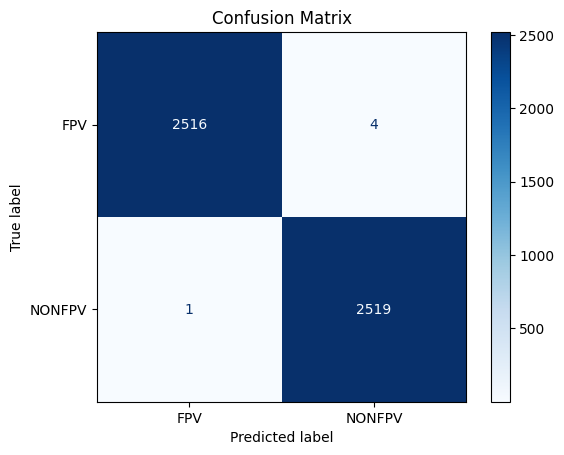


Classification Report:
              precision    recall  f1-score   support

         FPV     0.9996    0.9984    0.9990      2520
      NONFPV     0.9984    0.9996    0.9990      2520

    accuracy                         0.9990      5040
   macro avg     0.9990    0.9990    0.9990      5040
weighted avg     0.9990    0.9990    0.9990      5040


Showing 5 misclassified images:


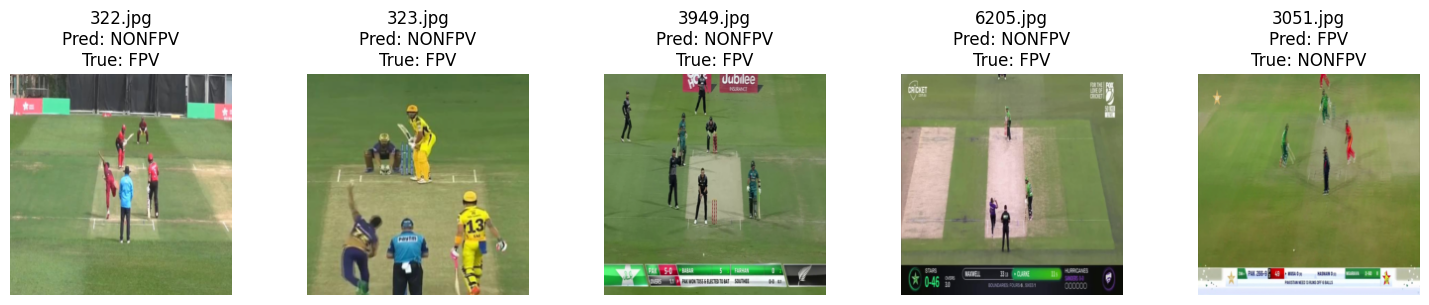

In [2]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import torch
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandAugment

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import CosineAnnealingLR

import torchmetrics
import timm
!pip -q install split-folders
import splitfolders

# =========================
# Setup
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.manual_seed(42)
np.random.seed(42)

# Hyperparameters
batch_size = 48
img_height, img_width = 224, 224
learning_rate = 2e-4
epochs = 20

# =========================
# Dataset Split
# =========================
os.makedirs('/kaggle/working/Cricket', exist_ok=True)
splitfolders.ratio(
    '/kaggle/input/fpv-dataset/Hybrid_Dataset',
    output='/kaggle/working/Cricket',
    seed=42,
    ratio=(.5, .1, .4),  # train, val, test
    move=False
)

# =========================
# DataModule
# =========================
class FireDataModule(pl.LightningDataModule):
    def __init__(self, path="/kaggle/working/Cricket"):
        super().__init__()
        self.PATH = path

    def setup(self, stage=None):
        train_transform = Compose([
            Resize((img_height, img_width)),
            RandAugment(num_ops=2, magnitude=9),
            ToTensor(),
            Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        test_transform = Compose([
            Resize((img_height, img_width)),
            ToTensor(),
            Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        if stage in ("fit", None):
            self.train = datasets.ImageFolder(os.path.join(self.PATH, 'train'), transform=train_transform)
            self.val = datasets.ImageFolder(os.path.join(self.PATH, 'val'), transform=test_transform)
        if stage in ("test", None):
            self.test = datasets.ImageFolder(os.path.join(self.PATH, 'test'), transform=test_transform)

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=batch_size, num_workers=2)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=batch_size, num_workers=2)

# =========================
# Model
# =========================
class PretrainedMobileNetV3(pl.LightningModule):
    def __init__(self, learning_rate=2e-4):
        super().__init__()
        self.save_hyperparameters()
        # Binary classification -> output 1 logit
        self.model = timm.create_model("mobilenetv3_small_100", pretrained=True, num_classes=1)

        # 🔒 Freeze block 2 and block 4
        for idx in [0,3,5]:
            for param in self.model.blocks[idx].parameters():
                param.requires_grad = False

        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.val_acc = torchmetrics.Accuracy(task="binary")
        self.test_acc = torchmetrics.Accuracy(task="binary")
        self.test_precision = torchmetrics.Precision(task="binary", average='macro')
        self.test_recall = torchmetrics.Recall(task="binary", average='macro')
        self.test_f1 = torchmetrics.F1Score(task="binary", average='macro')

    def forward(self, x):
        return self.model(x).squeeze(1)  # shape: [B]

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        acc = self.train_acc(preds, y.int())
        self.log("train_loss", loss, on_epoch=True)
        self.log("train_acc", acc, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        acc = self.val_acc(preds, y.int())
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True)
        return {"val_loss": loss, "val_acc": acc}

    def on_train_epoch_end(self):
        train_loss = self.trainer.callback_metrics.get("train_loss")
        train_acc = self.trainer.callback_metrics.get("train_acc")
        val_loss = self.trainer.callback_metrics.get("val_loss")
        val_acc = self.trainer.callback_metrics.get("val_acc")
        print(f"Epoch {self.current_epoch + 1}: "
              f"[Train] Loss: {train_loss:.4f} | Acc: {train_acc:.4f} || "
              f"[Val] Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    def test_step(self, batch, _):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        self.test_acc(preds, y.int())
        self.test_precision(preds, y.int())
        self.test_recall(preds, y.int())
        self.test_f1(preds, y.int())
        self.log_dict({
            "test_loss": loss,
            "test_acc": self.test_acc,
            "test_precision": self.test_precision,
            "test_recall": self.test_recall,
            "test_f1": self.test_f1
        }, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.learning_rate, weight_decay=0.05)
        scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

# =========================
# Dataset Stats
# =========================
def print_dataset_statistics(data_module):
    train_dataset = data_module.train
    val_dataset = data_module.val
    test_dataset = data_module.test

    def count_per_class(dataset):
        counts = {cls: 0 for cls in dataset.classes}
        for _, label in dataset.samples:
            counts[dataset.classes[label]] += 1
        return counts

    print("\n========== Dataset Statistics ==========")
    print(f"Classes: {train_dataset.classes}")
    print(f"Total Training Samples: {len(train_dataset)} | {count_per_class(train_dataset)}")
    print(f"Total Validation Samples: {len(val_dataset)} | {count_per_class(val_dataset)}")
    print(f"Total Testing Samples: {len(test_dataset)} | {count_per_class(test_dataset)}")
    print(f"Total Samples : {len(train_dataset)+len(val_dataset)+len(test_dataset)}")
    print("========================================\n")

# =========================
# Training
# =========================
data_module = FireDataModule()
data_module.setup()
print_dataset_statistics(data_module)

mobilenet_model = PretrainedMobileNetV3()

callbacks = [
    ModelCheckpoint(monitor="val_loss", dirpath="/kaggle/working/mobilenetv3",
                    filename="mobilenetv3-{epoch:02d}-{val_loss:.5f}", save_top_k=1, mode="min"),
    EarlyStopping(monitor="val_loss", patience=3, mode="min"),
    LearningRateMonitor(logging_interval='epoch')
]

logger = CSVLogger(save_dir="/kaggle/working/mobilenetv3", name="mobilenetv3_logs")

trainer = pl.Trainer(
    max_epochs=epochs,
    accelerator="auto",
    callbacks=callbacks,
    logger=logger,
    log_every_n_steps=1
)

start = time.time()
trainer.fit(mobilenet_model, datamodule=data_module)
end = time.time()
print(f"\nTotal Training Time: {int((end - start) // 60)} min")

# =========================
# Evaluation
# =========================
def evaluate_model(model, data_module):
    model.eval().to(device)
    all_preds, all_labels, misclassified_images = [], [], []
    test_loader = data_module.test_dataloader()
    start_time = time.time()
    total_images = 0
    sample_paths = test_loader.dataset.samples

    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = torch.sigmoid(logits)
            preds_label = (preds > 0.5).long()
            all_preds.extend(preds_label.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

            batch_paths = [sample_paths[i][0] for i in range(batch_idx * test_loader.batch_size,
                                                            batch_idx * test_loader.batch_size + len(y))]
            for i in range(len(y)):
                if preds_label[i] != y[i]:
                    misclassified_images.append((
                        x[i].cpu(),
                        preds_label[i].item(),
                        y[i].item(),
                        batch_paths[i]
                    ))
            total_images += x.size(0)

    elapsed_time = time.time() - start_time
    fps = total_images / elapsed_time
    avg_time_per_image = elapsed_time / total_images

    print(f"\nInference Performance:")
    print(f"Total images:         {total_images}")
    print(f"Total inference time: {elapsed_time:.2f} seconds")
    print(f"Average FPS:          {fps:.2f} images/second")
    print(f"Avg time/image:       {avg_time_per_image:.4f} seconds")

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(cm, display_labels=test_loader.dataset.classes)
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()


    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4, target_names=test_loader.dataset.classes))

    if misclassified_images:
        print(f"\nShowing {len(misclassified_images)} misclassified images:")
        class_names = test_loader.dataset.classes
        cols = 5
        rows = (len(misclassified_images) + cols - 1) // cols
        plt.figure(figsize=(cols * 3, rows * 3))
        for idx, (img_tensor, pred, true, file_path) in enumerate(misclassified_images):
            img = img_tensor.permute(1, 2, 0).numpy()
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img = np.clip(img, 0, 1)
            plt.subplot(rows, cols, idx + 1)
            plt.imshow(img)
            filename = file_path.split("/")[-1]
            plt.title(f"{filename}\nPred: {class_names[pred]}\nTrue: {class_names[true]}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("\nNo misclassified images found.")

mobilenet_model.to(device)
evaluate_model(mobilenet_model, data_module)


In [6]:
!pip install -q ptflops

import torch
import time
from ptflops import get_model_complexity_info

# ============================================================
# 🔧 Benchmark GPU + CPU in one call
# ============================================================
def benchmark_my_model(model, model_name="MyModel", input_size=(3,224,224), n_runs=30):
    devices = {
        "GPU": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        "CPU": torch.device("cpu")
    }

    for device_name, device in devices.items():
        #print(f"\n============================")
#        print(f"🔍 {model_name} on {device_name}")
        #print(f"============================")

        test_model = model.to(device)
        test_model.eval()

        dummy_input = torch.randn(1, *input_size).to(device)

        # ---- FLOPs + Params ----
        with torch.no_grad():
            macs, params = get_model_complexity_info(
                test_model, input_size, as_strings=False, verbose=False
            )
            flops = 2 * macs  # MAC ≈ 2 FLOPs

        # ---- Warm-up ----
        for _ in range(5):
            _ = test_model(dummy_input)

        # ---- Inference Time ----
        if device.type == "cuda":
            torch.cuda.synchronize()

        start = time.time()
        for _ in range(n_runs):
            _ = test_model(dummy_input)
        if device.type == "cuda":
            torch.cuda.synchronize()

        end = time.time()

        avg_latency = (end - start) / n_runs
        throughput = 1.0 / avg_latency

        # ---- Print Summary ----
        print(f"Parameters : {params/1e6:.2f} M")
        print(f"FLOPs      : {flops/1e9:.2f} GFLOPs")
        print(f"Latency    : {avg_latency*1000:.2f} ms")
        print(f"Throughput : {throughput:.2f} FPS")
        print("----------------------------")
benchmark_my_model(mobilenet_model, "MobileNetV3")


MobileNetV3(
  4.18 M, 76.192% Params, 217.68 MMac, 98.926% MACs, 
  (conv_stem): Conv2d(432, 0.008% Params, 5.42 MMac, 2.463% MACs, 3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    0, 0.000% Params, 0.0 Mac, 0.000% MACs, 16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
    (act): Hardswish(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
  )
  (blocks): Sequential(
    2.95 M, 53.750% Params, 210.98 MMac, 95.883% MACs, 
    (0): Sequential(
      400, 0.007% Params, 5.22 MMac, 2.372% MACs, 
      (0): DepthwiseSeparableConv(
        400, 0.007% Params, 5.22 MMac, 2.372% MACs, 
        (conv_dw): Conv2d(144, 0.003% Params, 1.81 MMac, 0.821% MACs, 16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (bn1): BatchNormAct2d(
          0, 0.000% Params, 200.7 KMac, 0.091% MACs, 16, eps=1e-05, momentum=0.1, affine=True, track_running

# MobileNetV3 Small

Using device: cuda


Copying files: 12600 files [01:23, 151.40 files/s]



========== Dataset Statistics ==========
Classes: ['FPV', 'NONFPV']
Total Training Samples: 6300 | {'FPV': 3150, 'NONFPV': 3150}
Total Validation Samples: 1260 | {'FPV': 630, 'NONFPV': 630}
Total Testing Samples: 5040 | {'FPV': 2520, 'NONFPV': 2520}
Total Samples : 12600



model.safetensors:   0%|          | 0.00/10.2M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /kaggle/working/mobilenetv3 exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: [Train] Loss: 0.2250 | Acc: 0.9683 || [Val] Loss: 0.0158 | Acc: 0.9937


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: [Train] Loss: 0.0441 | Acc: 0.9900 || [Val] Loss: 0.0119 | Acc: 0.9968


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: [Train] Loss: 0.0404 | Acc: 0.9917 || [Val] Loss: 0.0060 | Acc: 0.9976


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: [Train] Loss: 0.0257 | Acc: 0.9938 || [Val] Loss: 0.0096 | Acc: 0.9968


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: [Train] Loss: 0.0137 | Acc: 0.9965 || [Val] Loss: 0.0011 | Acc: 1.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: [Train] Loss: 0.0115 | Acc: 0.9967 || [Val] Loss: 0.0024 | Acc: 0.9992


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: [Train] Loss: 0.0135 | Acc: 0.9956 || [Val] Loss: 0.0050 | Acc: 0.9968


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: [Train] Loss: 0.0106 | Acc: 0.9976 || [Val] Loss: 0.0029 | Acc: 0.9984

Total Training Time: 8 min

Inference Performance:
Total images:         5040
Total inference time: 43.02 seconds
Average FPS:          117.15 images/second
Avg time/image:       0.0085 seconds


<Figure size 600x500 with 0 Axes>

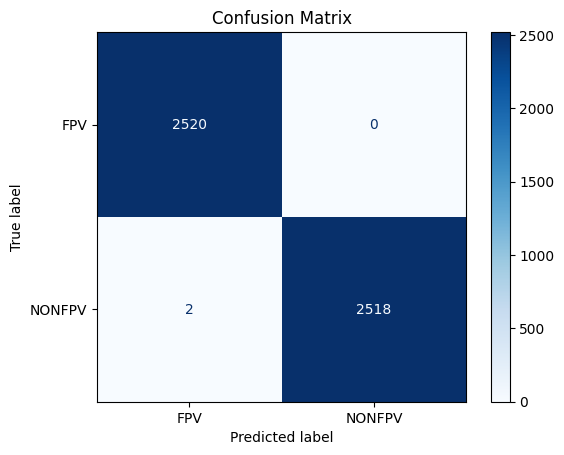


Classification Report:
              precision    recall  f1-score   support

         FPV     0.9992    1.0000    0.9996      2520
      NONFPV     1.0000    0.9992    0.9996      2520

    accuracy                         0.9996      5040
   macro avg     0.9996    0.9996    0.9996      5040
weighted avg     0.9996    0.9996    0.9996      5040


Showing 2 misclassified images:


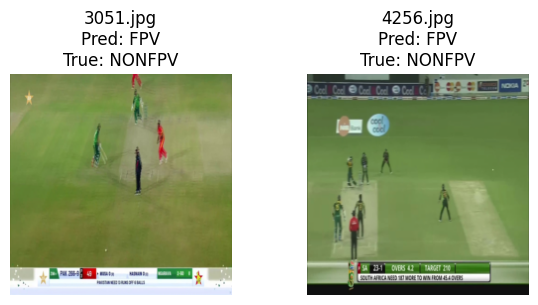

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import torch
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandAugment

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import CosineAnnealingLR

import torchmetrics
import timm
!pip -q install split-folders
import splitfolders

# =========================
# Setup
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.manual_seed(42)
np.random.seed(42)

# Hyperparameters
batch_size = 48
img_height, img_width = 224, 224
learning_rate = 2e-4
epochs = 20

# =========================
# Dataset Split
# =========================
os.makedirs('/kaggle/working/Cricket', exist_ok=True)
splitfolders.ratio(
    '/kaggle/input/fpv-dataset/Hybrid_Dataset',
    output='/kaggle/working/Cricket',
    seed=42,
    ratio=(.5, .1, .4),  # train, val, test
    move=False
)

# =========================
# DataModule
# =========================
class FireDataModule(pl.LightningDataModule):
    def __init__(self, path="/kaggle/working/Cricket"):
        super().__init__()
        self.PATH = path

    def setup(self, stage=None):
        train_transform = Compose([
            Resize((img_height, img_width)),
            RandAugment(num_ops=2, magnitude=9),
            ToTensor(),
            Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        test_transform = Compose([
            Resize((img_height, img_width)),
            ToTensor(),
            Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        if stage in ("fit", None):
            self.train = datasets.ImageFolder(os.path.join(self.PATH, 'train'), transform=train_transform)
            self.val = datasets.ImageFolder(os.path.join(self.PATH, 'val'), transform=test_transform)
        if stage in ("test", None):
            self.test = datasets.ImageFolder(os.path.join(self.PATH, 'test'), transform=test_transform)

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=batch_size, num_workers=2)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=batch_size, num_workers=2)

# =========================
# Model
# =========================
class PretrainedMobileNetV3(pl.LightningModule):
    def __init__(self, learning_rate=2e-4):
        super().__init__()
        self.save_hyperparameters()
        # Binary classification -> output 1 logit
        self.model = timm.create_model("mobilenetv3_small_100", pretrained=True, num_classes=1)

        # 🔒 Freeze block 2 and block 4
        for idx in [0,3,5]:
            for param in self.model.blocks[idx].parameters():
                param.requires_grad = False

        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.val_acc = torchmetrics.Accuracy(task="binary")
        self.test_acc = torchmetrics.Accuracy(task="binary")
        self.test_precision = torchmetrics.Precision(task="binary", average='macro')
        self.test_recall = torchmetrics.Recall(task="binary", average='macro')
        self.test_f1 = torchmetrics.F1Score(task="binary", average='macro')

    def forward(self, x):
        return self.model(x).squeeze(1)  # shape: [B]

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        acc = self.train_acc(preds, y.int())
        self.log("train_loss", loss, on_epoch=True)
        self.log("train_acc", acc, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        acc = self.val_acc(preds, y.int())
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True)
        return {"val_loss": loss, "val_acc": acc}

    def on_train_epoch_end(self):
        train_loss = self.trainer.callback_metrics.get("train_loss")
        train_acc = self.trainer.callback_metrics.get("train_acc")
        val_loss = self.trainer.callback_metrics.get("val_loss")
        val_acc = self.trainer.callback_metrics.get("val_acc")
        print(f"Epoch {self.current_epoch + 1}: "
              f"[Train] Loss: {train_loss:.4f} | Acc: {train_acc:.4f} || "
              f"[Val] Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    def test_step(self, batch, _):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        self.test_acc(preds, y.int())
        self.test_precision(preds, y.int())
        self.test_recall(preds, y.int())
        self.test_f1(preds, y.int())
        self.log_dict({
            "test_loss": loss,
            "test_acc": self.test_acc,
            "test_precision": self.test_precision,
            "test_recall": self.test_recall,
            "test_f1": self.test_f1
        }, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.learning_rate, weight_decay=0.05)
        scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

# =========================
# Dataset Stats
# =========================
def print_dataset_statistics(data_module):
    train_dataset = data_module.train
    val_dataset = data_module.val
    test_dataset = data_module.test

    def count_per_class(dataset):
        counts = {cls: 0 for cls in dataset.classes}
        for _, label in dataset.samples:
            counts[dataset.classes[label]] += 1
        return counts

    print("\n========== Dataset Statistics ==========")
    print(f"Classes: {train_dataset.classes}")
    print(f"Total Training Samples: {len(train_dataset)} | {count_per_class(train_dataset)}")
    print(f"Total Validation Samples: {len(val_dataset)} | {count_per_class(val_dataset)}")
    print(f"Total Testing Samples: {len(test_dataset)} | {count_per_class(test_dataset)}")
    print(f"Total Samples : {len(train_dataset)+len(val_dataset)+len(test_dataset)}")
    print("========================================\n")

# =========================
# Training
# =========================
data_module = FireDataModule()
data_module.setup()
print_dataset_statistics(data_module)

mobilenet_model = PretrainedMobileNetV3()

callbacks = [
    ModelCheckpoint(monitor="val_loss", dirpath="/kaggle/working/mobilenetv3",
                    filename="mobilenetv3-{epoch:02d}-{val_loss:.5f}", save_top_k=1, mode="min"),
    EarlyStopping(monitor="val_loss", patience=3, mode="min"),
    LearningRateMonitor(logging_interval='epoch')
]

logger = CSVLogger(save_dir="/kaggle/working/mobilenetv3", name="mobilenetv3_logs")

trainer = pl.Trainer(
    max_epochs=epochs,
    accelerator="auto",
    callbacks=callbacks,
    logger=logger,
    log_every_n_steps=1
)

start = time.time()
trainer.fit(mobilenet_model, datamodule=data_module)
end = time.time()
print(f"\nTotal Training Time: {int((end - start) // 60)} min")

# =========================
# Evaluation
# =========================
def evaluate_model(model, data_module):
    model.eval().to(device)
    all_preds, all_labels, misclassified_images = [], [], []
    test_loader = data_module.test_dataloader()
    start_time = time.time()
    total_images = 0
    sample_paths = test_loader.dataset.samples

    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = torch.sigmoid(logits)
            preds_label = (preds > 0.5).long()
            all_preds.extend(preds_label.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

            batch_paths = [sample_paths[i][0] for i in range(batch_idx * test_loader.batch_size,
                                                            batch_idx * test_loader.batch_size + len(y))]
            for i in range(len(y)):
                if preds_label[i] != y[i]:
                    misclassified_images.append((
                        x[i].cpu(),
                        preds_label[i].item(),
                        y[i].item(),
                        batch_paths[i]
                    ))
            total_images += x.size(0)

    elapsed_time = time.time() - start_time
    fps = total_images / elapsed_time
    avg_time_per_image = elapsed_time / total_images

    print(f"\nInference Performance:")
    print(f"Total images:         {total_images}")
    print(f"Total inference time: {elapsed_time:.2f} seconds")
    print(f"Average FPS:          {fps:.2f} images/second")
    print(f"Avg time/image:       {avg_time_per_image:.4f} seconds")

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(cm, display_labels=test_loader.dataset.classes)
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()


    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4, target_names=test_loader.dataset.classes))

    if misclassified_images:
        print(f"\nShowing {len(misclassified_images)} misclassified images:")
        class_names = test_loader.dataset.classes
        cols = 5
        rows = (len(misclassified_images) + cols - 1) // cols
        plt.figure(figsize=(cols * 3, rows * 3))
        for idx, (img_tensor, pred, true, file_path) in enumerate(misclassified_images):
            img = img_tensor.permute(1, 2, 0).numpy()
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img = np.clip(img, 0, 1)
            plt.subplot(rows, cols, idx + 1)
            plt.imshow(img)
            filename = file_path.split("/")[-1]
            plt.title(f"{filename}\nPred: {class_names[pred]}\nTrue: {class_names[true]}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("\nNo misclassified images found.")

mobilenet_model.to(device)
evaluate_model(mobilenet_model, data_module)


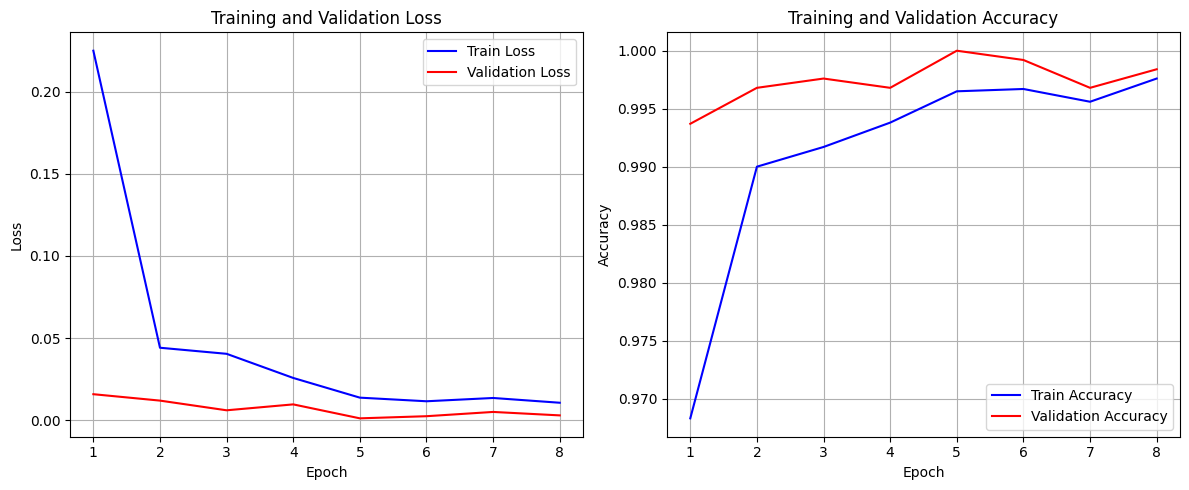

In [78]:
import matplotlib.pyplot as plt

# Training and validation logs
epochs = list(range(1, 9))

train_loss = [0.2250, 0.0441, 0.0404, 0.0257, 0.0137, 0.0115, 0.0135, 0.0106]
val_loss   = [0.0158, 0.0119, 0.0060, 0.0096, 0.0011, 0.0024, 0.0050, 0.0029]

train_acc = [0.9683, 0.9900, 0.9917, 0.9938, 0.9965, 0.9967, 0.9956, 0.9976]
val_acc   = [0.9937, 0.9968, 0.9976, 0.9968, 1.0000, 0.9992, 0.9968, 0.9984]

# Create subplots
plt.figure(figsize=(12,5))

# Plot Loss
plt.subplot(1,2,1)
plt.plot(epochs, train_loss, color="blue", label="Train Loss")
plt.plot(epochs, val_loss, color="red", label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1,2,2)
plt.plot(epochs, train_acc, color="blue", label="Train Accuracy")
plt.plot(epochs, val_acc, color="red", label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)

# Adjust layout and save
plt.tight_layout()
plt.savefig("train_val_curves.png", dpi=300)
plt.show()


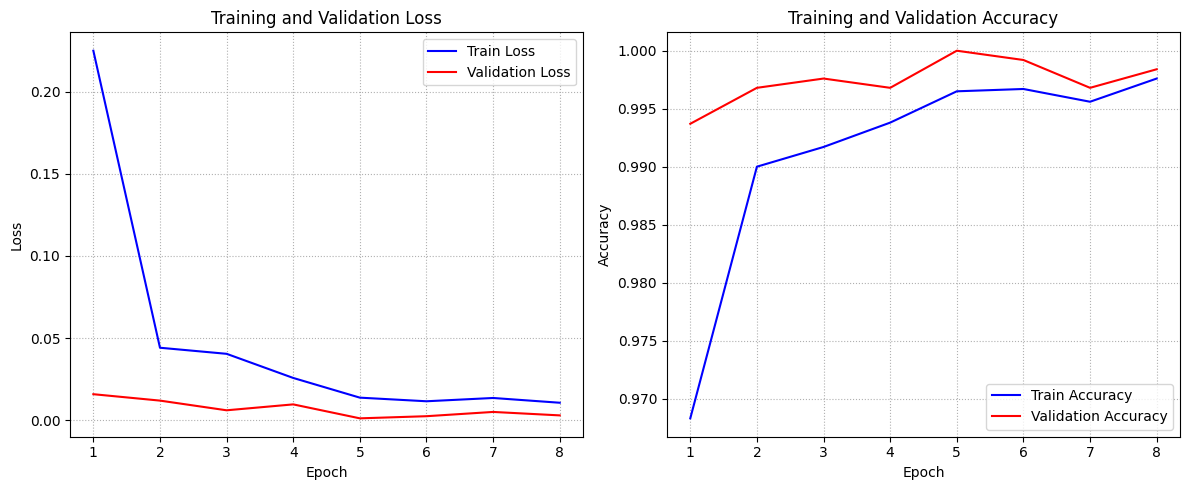

In [79]:
import matplotlib.pyplot as plt

# Training and validation logs
epochs = list(range(1, 9))

train_loss = [0.2250, 0.0441, 0.0404, 0.0257, 0.0137, 0.0115, 0.0135, 0.0106]
val_loss   = [0.0158, 0.0119, 0.0060, 0.0096, 0.0011, 0.0024, 0.0050, 0.0029]

train_acc = [0.9683, 0.9900, 0.9917, 0.9938, 0.9965, 0.9967, 0.9956, 0.9976]
val_acc   = [0.9937, 0.9968, 0.9976, 0.9968, 1.0000, 0.9992, 0.9968, 0.9984]

# Create subplots
plt.figure(figsize=(12,5))

# Plot Loss
plt.subplot(1,2,1)
plt.plot(epochs, train_loss, color="blue", label="Train Loss")
plt.plot(epochs, val_loss, color="red", label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True, linestyle=':')  # Dotted grid

# Plot Accuracy
plt.subplot(1,2,2)
plt.plot(epochs, train_acc, color="blue", label="Train Accuracy")
plt.plot(epochs, val_acc, color="red", label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True, linestyle=':')  # Dotted grid

# Adjust layout and save
plt.tight_layout()
plt.savefig("train_val_curves.png", dpi=300)
plt.show()


Using device: cuda


Copying files: 12600 files [00:22, 563.26 files/s] 



========== Dataset Statistics ==========
Classes: ['FPV', 'NONFPV']
Total Training Samples: 6300 | {'FPV': 3150, 'NONFPV': 3150}
Total Validation Samples: 1260 | {'FPV': 630, 'NONFPV': 630}
Total Testing Samples: 5040 | {'FPV': 2520, 'NONFPV': 2520}
Total Samples : 12600



/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /kaggle/working/mobilenetv3 exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: [Train] Loss: 0.2297 | Acc: 0.9683 || [Val] Loss: 0.0101 | Acc: 0.9960


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: [Train] Loss: 0.0490 | Acc: 0.9890 || [Val] Loss: 0.0194 | Acc: 0.9952


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: [Train] Loss: 0.0385 | Acc: 0.9924 || [Val] Loss: 0.0042 | Acc: 0.9992


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: [Train] Loss: 0.0154 | Acc: 0.9954 || [Val] Loss: 0.0020 | Acc: 0.9992


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: [Train] Loss: 0.0112 | Acc: 0.9979 || [Val] Loss: 0.0080 | Acc: 0.9984


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: [Train] Loss: 0.0231 | Acc: 0.9956 || [Val] Loss: 0.0009 | Acc: 1.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: [Train] Loss: 0.0164 | Acc: 0.9952 || [Val] Loss: 0.0010 | Acc: 0.9992


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: [Train] Loss: 0.0115 | Acc: 0.9973 || [Val] Loss: 0.0050 | Acc: 0.9992


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: [Train] Loss: 0.0058 | Acc: 0.9986 || [Val] Loss: 0.0032 | Acc: 0.9992

Total Training Time: 10 min

Inference Performance:
Total images:         5040
Total inference time: 41.42 seconds
Average FPS:          121.67 images/second
Avg time/image:       0.0082 seconds


<Figure size 600x500 with 0 Axes>

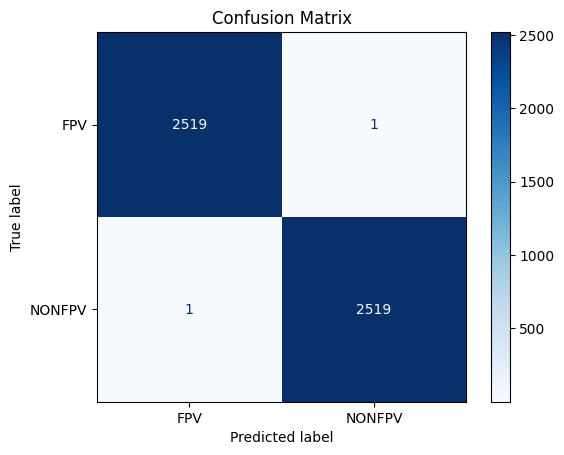


Classification Report:
              precision    recall  f1-score   support

         FPV     0.9996    0.9996    0.9996      2520
      NONFPV     0.9996    0.9996    0.9996      2520

    accuracy                         0.9996      5040
   macro avg     0.9996    0.9996    0.9996      5040
weighted avg     0.9996    0.9996    0.9996      5040


Showing 2 misclassified images:


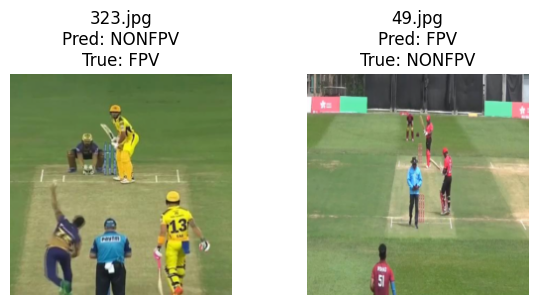

In [2]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import torch
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandAugment

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import CosineAnnealingLR

import torchmetrics
import timm
!pip -q install split-folders
import splitfolders

# =========================
# Setup
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.manual_seed(42)
np.random.seed(42)

# Hyperparameters
batch_size = 48
img_height, img_width = 224, 224
learning_rate = 2e-4
epochs = 20

# =========================
# Dataset Split
# =========================
os.makedirs('/kaggle/working/Cricket', exist_ok=True)
splitfolders.ratio(
    '/kaggle/input/fpv-dataset/Hybrid_Dataset',
    output='/kaggle/working/Cricket',
    seed=42,
    ratio=(.5, .1, .4),  # train, val, test
    move=False
)

# =========================
# DataModule
# =========================
class FireDataModule(pl.LightningDataModule):
    def __init__(self, path="/kaggle/working/Cricket"):
        super().__init__()
        self.PATH = path

    def setup(self, stage=None):
        train_transform = Compose([
            Resize((img_height, img_width)),
            RandAugment(num_ops=2, magnitude=9),
            ToTensor(),
            Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        test_transform = Compose([
            Resize((img_height, img_width)),
            ToTensor(),
            Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        if stage in ("fit", None):
            self.train = datasets.ImageFolder(os.path.join(self.PATH, 'train'), transform=train_transform)
            self.val = datasets.ImageFolder(os.path.join(self.PATH, 'val'), transform=test_transform)
        if stage in ("test", None):
            self.test = datasets.ImageFolder(os.path.join(self.PATH, 'test'), transform=test_transform)

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=batch_size, num_workers=2)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=batch_size, num_workers=2)

# =========================
# Model
# =========================
class PretrainedMobileNetV3(pl.LightningModule):
    def __init__(self, learning_rate=2e-4):
        super().__init__()
        self.save_hyperparameters()
        # Binary classification -> output 1 logit
        self.model = timm.create_model("mobilenetv3_small_100", pretrained=True, num_classes=1)

        # 🔒 Freeze block 2 and block 4
        for idx in [0,3,5]:
            for param in self.model.blocks[idx].parameters():
                param.requires_grad = False

        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.val_acc = torchmetrics.Accuracy(task="binary")
        self.test_acc = torchmetrics.Accuracy(task="binary")
        self.test_precision = torchmetrics.Precision(task="binary", average='macro')
        self.test_recall = torchmetrics.Recall(task="binary", average='macro')
        self.test_f1 = torchmetrics.F1Score(task="binary", average='macro')

    def forward(self, x):
        return self.model(x).squeeze(1)  # shape: [B]

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        acc = self.train_acc(preds, y.int())
        self.log("train_loss", loss, on_epoch=True)
        self.log("train_acc", acc, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        acc = self.val_acc(preds, y.int())
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True)
        return {"val_loss": loss, "val_acc": acc}

    def on_train_epoch_end(self):
        train_loss = self.trainer.callback_metrics.get("train_loss")
        train_acc = self.trainer.callback_metrics.get("train_acc")
        val_loss = self.trainer.callback_metrics.get("val_loss")
        val_acc = self.trainer.callback_metrics.get("val_acc")
        print(f"Epoch {self.current_epoch + 1}: "
              f"[Train] Loss: {train_loss:.4f} | Acc: {train_acc:.4f} || "
              f"[Val] Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    def test_step(self, batch, _):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        self.test_acc(preds, y.int())
        self.test_precision(preds, y.int())
        self.test_recall(preds, y.int())
        self.test_f1(preds, y.int())
        self.log_dict({
            "test_loss": loss,
            "test_acc": self.test_acc,
            "test_precision": self.test_precision,
            "test_recall": self.test_recall,
            "test_f1": self.test_f1
        }, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.learning_rate, weight_decay=0.05)
        scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

# =========================
# Dataset Stats
# =========================
def print_dataset_statistics(data_module):
    train_dataset = data_module.train
    val_dataset = data_module.val
    test_dataset = data_module.test

    def count_per_class(dataset):
        counts = {cls: 0 for cls in dataset.classes}
        for _, label in dataset.samples:
            counts[dataset.classes[label]] += 1
        return counts

    print("\n========== Dataset Statistics ==========")
    print(f"Classes: {train_dataset.classes}")
    print(f"Total Training Samples: {len(train_dataset)} | {count_per_class(train_dataset)}")
    print(f"Total Validation Samples: {len(val_dataset)} | {count_per_class(val_dataset)}")
    print(f"Total Testing Samples: {len(test_dataset)} | {count_per_class(test_dataset)}")
    print(f"Total Samples : {len(train_dataset)+len(val_dataset)+len(test_dataset)}")
    print("========================================\n")

# =========================
# Training
# =========================
data_module = FireDataModule()
data_module.setup()
print_dataset_statistics(data_module)

mobilenet_model = PretrainedMobileNetV3()

callbacks = [
    ModelCheckpoint(monitor="val_loss", dirpath="/kaggle/working/mobilenetv3",
                    filename="mobilenetv3-{epoch:02d}-{val_loss:.5f}", save_top_k=1, mode="min"),
    EarlyStopping(monitor="val_loss", patience=3, mode="min"),
    LearningRateMonitor(logging_interval='epoch')
]

logger = CSVLogger(save_dir="/kaggle/working/mobilenetv3", name="mobilenetv3_logs")

trainer = pl.Trainer(
    max_epochs=epochs,
    accelerator="auto",
    callbacks=callbacks,
    logger=logger,
    log_every_n_steps=1
)

start = time.time()
trainer.fit(mobilenet_model, datamodule=data_module)
end = time.time()
print(f"\nTotal Training Time: {int((end - start) // 60)} min")

# =========================
# Evaluation
# =========================
def evaluate_model(model, data_module):
    model.eval().to(device)
    all_preds, all_labels, misclassified_images = [], [], []
    test_loader = data_module.test_dataloader()
    start_time = time.time()
    total_images = 0
    sample_paths = test_loader.dataset.samples

    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = torch.sigmoid(logits)
            preds_label = (preds > 0.5).long()
            all_preds.extend(preds_label.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

            batch_paths = [sample_paths[i][0] for i in range(batch_idx * test_loader.batch_size,
                                                            batch_idx * test_loader.batch_size + len(y))]
            for i in range(len(y)):
                if preds_label[i] != y[i]:
                    misclassified_images.append((
                        x[i].cpu(),
                        preds_label[i].item(),
                        y[i].item(),
                        batch_paths[i]
                    ))
            total_images += x.size(0)

    elapsed_time = time.time() - start_time
    fps = total_images / elapsed_time
    avg_time_per_image = elapsed_time / total_images

    print(f"\nInference Performance:")
    print(f"Total images:         {total_images}")
    print(f"Total inference time: {elapsed_time:.2f} seconds")
    print(f"Average FPS:          {fps:.2f} images/second")
    print(f"Avg time/image:       {avg_time_per_image:.4f} seconds")

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(cm, display_labels=test_loader.dataset.classes)
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()


    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4, target_names=test_loader.dataset.classes))

    if misclassified_images:
        print(f"\nShowing {len(misclassified_images)} misclassified images:")
        class_names = test_loader.dataset.classes
        cols = 5
        rows = (len(misclassified_images) + cols - 1) // cols
        plt.figure(figsize=(cols * 3, rows * 3))
        for idx, (img_tensor, pred, true, file_path) in enumerate(misclassified_images):
            img = img_tensor.permute(1, 2, 0).numpy()
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img = np.clip(img, 0, 1)
            plt.subplot(rows, cols, idx + 1)
            plt.imshow(img)
            filename = file_path.split("/")[-1]
            plt.title(f"{filename}\nPred: {class_names[pred]}\nTrue: {class_names[true]}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("\nNo misclassified images found.")

mobilenet_model.to(device)
evaluate_model(mobilenet_model, data_module)


# trained model2

In [66]:
!rm -r /kaggle/working/

rm: cannot remove '/kaggle/working/': Device or resource busy


In [67]:
os.makedirs('/kaggle/working/Cricket', exist_ok=True)
splitfolders.ratio(
    '/kaggle/input/fpv-dataset/Hybrid_Dataset',
    output='/kaggle/working/Cricket',
    seed=42,
    ratio=(.5, .1, .4),  # train, val, test
    move=False
)

Copying files: 12600 files [00:18, 674.54 files/s] 


In [68]:
# =========================
# DataModule
# =========================
class FireDataModule(pl.LightningDataModule):
    def __init__(self, path="/kaggle/working/Cricket"):
        super().__init__()
        self.PATH = path

    def setup(self, stage=None):
        train_transform = Compose([
            Resize((img_height, img_width)),
            RandAugment(num_ops=2, magnitude=9),
            ToTensor(),
            Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        test_transform = Compose([
            Resize((img_height, img_width)),
            ToTensor(),
            Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        if stage in ("fit", None):
            self.train = datasets.ImageFolder(os.path.join(self.PATH, 'train'), transform=train_transform)
            self.val = datasets.ImageFolder(os.path.join(self.PATH, 'val'), transform=test_transform)
        if stage in ("test", None):
            self.test = datasets.ImageFolder(os.path.join(self.PATH, 'test'), transform=test_transform)

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=batch_size, num_workers=2)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=batch_size, num_workers=2)

# =========================
# Model
# =========================
class PretrainedMobileNetV3(pl.LightningModule):
    def __init__(self, learning_rate=2e-4):
        super().__init__()
        self.save_hyperparameters()
        # Binary classification -> output 1 logit
        self.model = timm.create_model("mobilenetv3_small_100", pretrained=True, num_classes=1)

        # 🔒 Freeze block 2 and block 4
        for idx in [0,3,5]:
            for param in self.model.blocks[idx].parameters():
                param.requires_grad = False

        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.val_acc = torchmetrics.Accuracy(task="binary")
        self.test_acc = torchmetrics.Accuracy(task="binary")
        self.test_precision = torchmetrics.Precision(task="binary", average='macro')
        self.test_recall = torchmetrics.Recall(task="binary", average='macro')
        self.test_f1 = torchmetrics.F1Score(task="binary", average='macro')

    def forward(self, x):
        return self.model(x).squeeze(1)  # shape: [B]

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        acc = self.train_acc(preds, y.int())
        self.log("train_loss", loss, on_epoch=True)
        self.log("train_acc", acc, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        acc = self.val_acc(preds, y.int())
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True)
        return {"val_loss": loss, "val_acc": acc}

    def on_train_epoch_end(self):
        train_loss = self.trainer.callback_metrics.get("train_loss")
        train_acc = self.trainer.callback_metrics.get("train_acc")
        val_loss = self.trainer.callback_metrics.get("val_loss")
        val_acc = self.trainer.callback_metrics.get("val_acc")
        print(f"Epoch {self.current_epoch + 1}: "
              f"[Train] Loss: {train_loss:.4f} | Acc: {train_acc:.4f} || "
              f"[Val] Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    def test_step(self, batch, _):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        self.test_acc(preds, y.int())
        self.test_precision(preds, y.int())
        self.test_recall(preds, y.int())
        self.test_f1(preds, y.int())
        self.log_dict({
            "test_loss": loss,
            "test_acc": self.test_acc,
            "test_precision": self.test_precision,
            "test_recall": self.test_recall,
            "test_f1": self.test_f1
        }, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.learning_rate, weight_decay=0.05)
        scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

# =========================
# Dataset Stats
# =========================
def print_dataset_statistics(data_module):
    train_dataset = data_module.train
    val_dataset = data_module.val
    test_dataset = data_module.test

    def count_per_class(dataset):
        counts = {cls: 0 for cls in dataset.classes}
        for _, label in dataset.samples:
            counts[dataset.classes[label]] += 1
        return counts

    print("\n========== Dataset Statistics ==========")
    print(f"Classes: {train_dataset.classes}")
    print(f"Total Training Samples: {len(train_dataset)} | {count_per_class(train_dataset)}")
    print(f"Total Validation Samples: {len(val_dataset)} | {count_per_class(val_dataset)}")
    print(f"Total Testing Samples: {len(test_dataset)} | {count_per_class(test_dataset)}")
    print(f"Total Samples : {len(train_dataset)+len(val_dataset)+len(test_dataset)}")
    print("========================================\n")

# =========================
# Training
# =========================
data_module = FireDataModule()
data_module.setup()
print_dataset_statistics(data_module)

mobilenet_model = PretrainedMobileNetV3()



========== Dataset Statistics ==========
Classes: ['FPV', 'NONFPV']
Total Training Samples: 6300 | {'FPV': 3150, 'NONFPV': 3150}
Total Validation Samples: 1260 | {'FPV': 630, 'NONFPV': 630}
Total Testing Samples: 5040 | {'FPV': 2520, 'NONFPV': 2520}
Total Samples : 12600



In [69]:
# Path to your saved checkpoint
ckpt_path = "/kaggle/input/trained-model2/mobilenetv3(Accuracy-99.96)-epoch04-val_loss0.00105.ckpt"

# Load model with weights
model  = PretrainedMobileNetV3.load_from_checkpoint(
    ckpt_path,
    learning_rate=2e-4  # pass hyperparameters if required
)




Inference Performance:
Total images:         5040
Total inference time: 41.43 seconds
Average FPS:          121.65 images/second
Avg time/image:       0.0082 seconds


<Figure size 600x500 with 0 Axes>

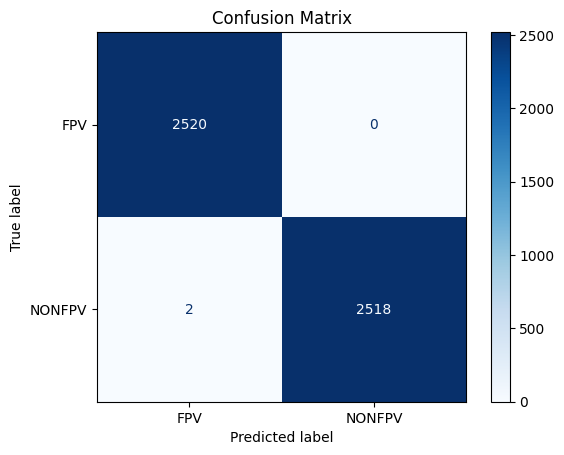


Classification Report:
              precision    recall  f1-score   support

         FPV     0.9992    1.0000    0.9996      2520
      NONFPV     1.0000    0.9992    0.9996      2520

    accuracy                         0.9996      5040
   macro avg     0.9996    0.9996    0.9996      5040
weighted avg     0.9996    0.9996    0.9996      5040


Showing 2 misclassified images:


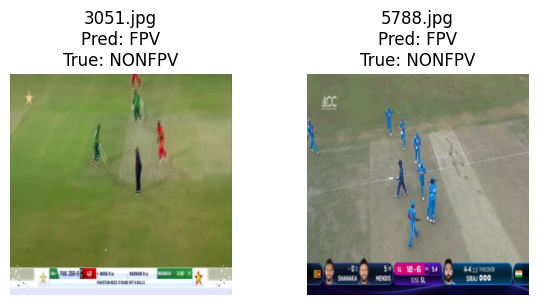

In [70]:

# =========================
# Evaluation
# =========================
def evaluate_model(model, data_module):
    model.eval().to(device)
    all_preds, all_labels, misclassified_images = [], [], []
    test_loader = data_module.test_dataloader()
    start_time = time.time()
    total_images = 0
    sample_paths = test_loader.dataset.samples

    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = torch.sigmoid(logits)
            preds_label = (preds > 0.5).long()
            all_preds.extend(preds_label.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

            batch_paths = [sample_paths[i][0] for i in range(batch_idx * test_loader.batch_size,
                                                            batch_idx * test_loader.batch_size + len(y))]
            for i in range(len(y)):
                if preds_label[i] != y[i]:
                    misclassified_images.append((
                        x[i].cpu(),
                        preds_label[i].item(),
                        y[i].item(),
                        batch_paths[i]
                    ))
            total_images += x.size(0)

    elapsed_time = time.time() - start_time
    fps = total_images / elapsed_time
    avg_time_per_image = elapsed_time / total_images

    print(f"\nInference Performance:")
    print(f"Total images:         {total_images}")
    print(f"Total inference time: {elapsed_time:.2f} seconds")
    print(f"Average FPS:          {fps:.2f} images/second")
    print(f"Avg time/image:       {avg_time_per_image:.4f} seconds")

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(cm, display_labels=test_loader.dataset.classes)
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()


    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4, target_names=test_loader.dataset.classes))

    if misclassified_images:
        print(f"\nShowing {len(misclassified_images)} misclassified images:")
        class_names = test_loader.dataset.classes
        cols = 5
        rows = (len(misclassified_images) + cols - 1) // cols
        plt.figure(figsize=(cols * 3, rows * 3))
        for idx, (img_tensor, pred, true, file_path) in enumerate(misclassified_images):
            img = img_tensor.permute(1, 2, 0).numpy()
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img = np.clip(img, 0, 1)
            plt.subplot(rows, cols, idx + 1)
            plt.imshow(img)
            filename = file_path.split("/")[-1]
            plt.title(f"{filename}\nPred: {class_names[pred]}\nTrue: {class_names[true]}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("\nNo misclassified images found.")

model.to(device)
evaluate_model(model, data_module)

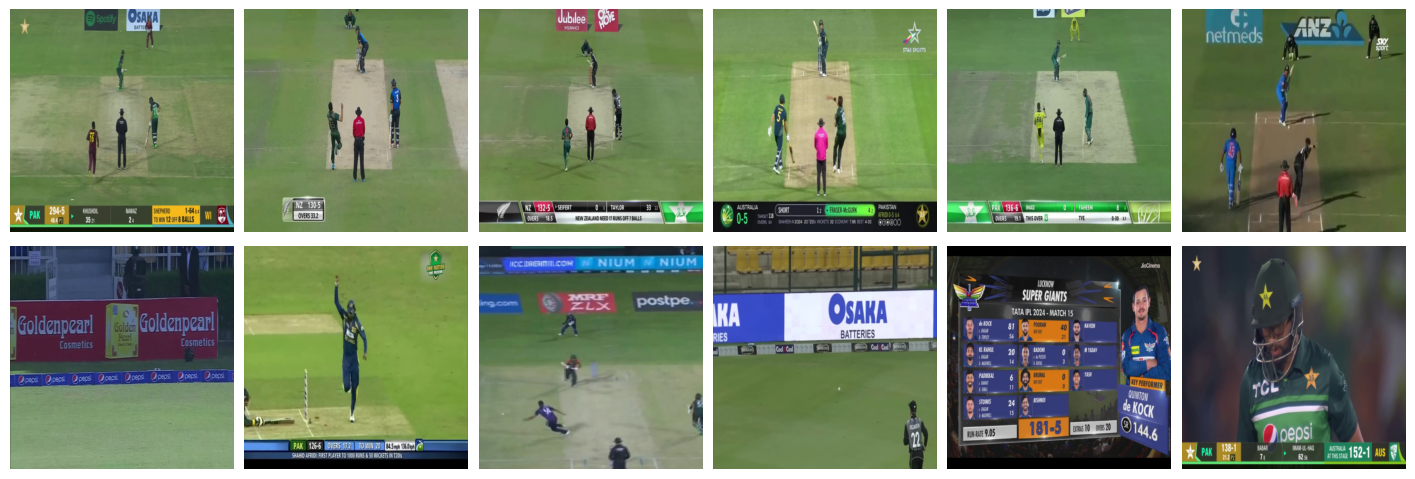

Saved predictions grid to fpv_vs_nonfpv.png


In [74]:
import random
import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np

def show_predictions(model, data_module, num_per_class=6, save_path="predictions.png"):
    model.eval().to(device)
    test_loader = data_module.test_dataloader()
    class_names = test_loader.dataset.classes  # e.g. ["FPV", "NonFPV"]

    preds_by_class = {cls: [] for cls in class_names}

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = torch.sigmoid(logits)
            preds_label = (preds > 0.5).long()

            for i in range(len(y)):
                pred_class = class_names[preds_label[i].item()]
                preds_by_class[pred_class].append(x[i].cpu())

    # Select 6 random frames from each class
    selected = {}
    for cls in class_names:
        if len(preds_by_class[cls]) >= num_per_class:
            selected[cls] = random.sample(preds_by_class[cls], num_per_class)
        else:
            selected[cls] = preds_by_class[cls]

    # Plotting
    fig, axes = plt.subplots(2, num_per_class, figsize=(3*num_per_class, 6))
    for row, cls in enumerate(class_names):
        for col, img_tensor in enumerate(selected[cls]):
            img = img_tensor.permute(1, 2, 0).numpy()
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # unnormalize
            img = np.clip(img, 0, 1)
            axes[row, col].imshow(img)
            axes[row, col].axis("off")

    # Add some spacing between frames
    plt.subplots_adjust(wspace=0.05, hspace=0.05)

    # Save before showing
    plt.savefig(save_path, bbox_inches="tight", pad_inches=0.1)
    plt.show()
    plt.close()

    print(f"Saved predictions grid to {save_path}")

# Call it
show_predictions(model, data_module, num_per_class=6, save_path="fpv_vs_nonfpv.png")

# Download FPV and Non-FPV frames

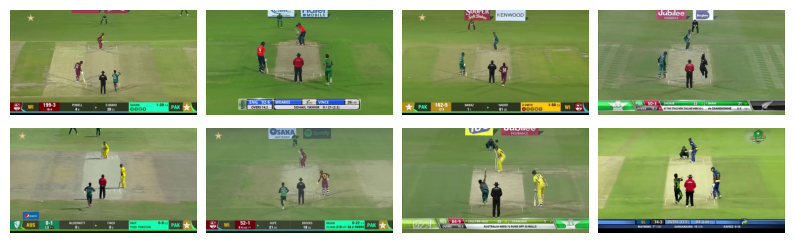

Saved grid image as fpv.png


In [43]:
import os
import matplotlib.pyplot as plt
import cv2
import random

# Path to your frames
path = "/kaggle/input/for-pictures-ytvideo-frames/Datasets/FPV"

# Get list of image files
frames = sorted([os.path.join(path, f) for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

# Select 8 random frames
selected_frames = random.sample(frames, 8)

# Create grid plot (2 rows, 4 columns)
fig, axes = plt.subplots(2, 4, figsize=(10, 3))

for idx, ax in enumerate(axes.flat):
    img = cv2.imread(selected_frames[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.axis("off")

# Add some spacing between frames
plt.subplots_adjust(wspace=0.05, hspace=0.05)  # try 0.05–0.2 for more spacing

# Save and show
output_file = "fpv.png"
plt.savefig(output_file, bbox_inches="tight", pad_inches=0)
plt.show()
plt.close()

print(f"Saved grid image as {output_file}")


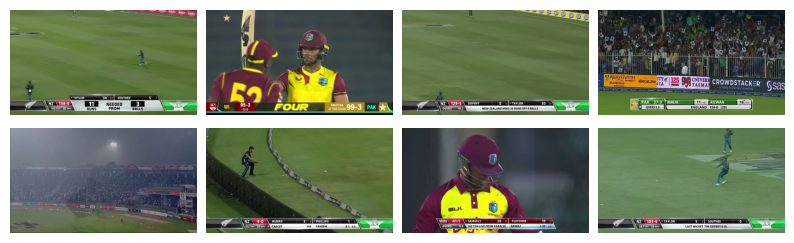

Saved grid image as nonfpv.png


In [51]:
import os
import matplotlib.pyplot as plt
import cv2
import random

# Path to your frames
path = "/kaggle/input/for-pictures-ytvideo-frames/Datasets/NONFPV"

# Get list of image files
frames = sorted([os.path.join(path, f) for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

# Select 8 random frames
selected_frames = random.sample(frames, 8)

# Create grid plot (2 rows, 4 columns)
fig, axes = plt.subplots(2, 4, figsize=(10, 3))

for idx, ax in enumerate(axes.flat):
    img = cv2.imread(selected_frames[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.axis("off")

# Add some spacing between frames
plt.subplots_adjust(wspace=0.05, hspace=0.05)  # try 0.05–0.2 for more spacing

# Save and show
output_file = "nonfpv.png"
plt.savefig(output_file, bbox_inches="tight", pad_inches=0)
plt.show()
plt.close()

print(f"Saved grid image as {output_file}")


Using device: cuda

========== Dataset Statistics ==========
Classes: ['FPV', 'NONFPV']
Total Training Samples: 6300 | {'FPV': 3150, 'NONFPV': 3150}
Total Testing Samples: 6300 | {'FPV': 3150, 'NONFPV': 3150}
Total Samples : 12600



Training: |          | 0/? [00:00<?, ?it/s]

Epoch 1: [Train] Loss: 0.2262 | Acc: 0.9694 
Epoch 2: [Train] Loss: 0.0749 | Acc: 0.9871 
Epoch 3: [Train] Loss: 0.0320 | Acc: 0.9933 
Epoch 4: [Train] Loss: 0.0150 | Acc: 0.9970 
Epoch 5: [Train] Loss: 0.0209 | Acc: 0.9938 
Epoch 6: [Train] Loss: 0.0065 | Acc: 0.9986 
Epoch 7: [Train] Loss: 0.0039 | Acc: 0.9983 
Epoch 8: [Train] Loss: 0.0055 | Acc: 0.9984 
Epoch 9: [Train] Loss: 0.0055 | Acc: 0.9984 
Epoch 10: [Train] Loss: 0.0052 | Acc: 0.9979 

Total Training Time: 9 min

Inference Performance:
Total images:         6300
Total inference time: 50.99 seconds
Average FPS:          123.55 images/second
Avg time/image:       0.0081 seconds


<Figure size 600x500 with 0 Axes>

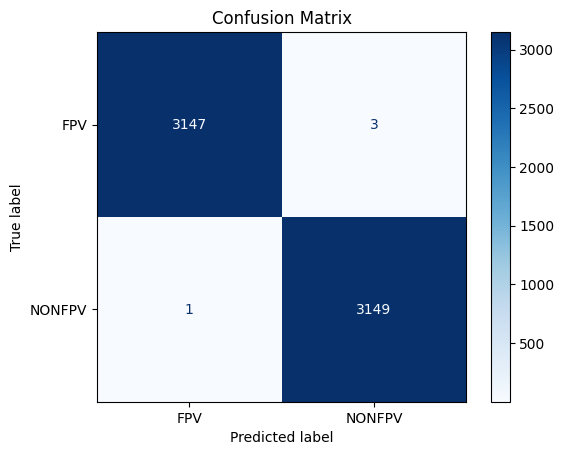


Classification Report:
              precision    recall  f1-score   support

         FPV     0.9997    0.9990    0.9994      3150
      NONFPV     0.9990    0.9997    0.9994      3150

    accuracy                         0.9994      6300
   macro avg     0.9994    0.9994    0.9994      6300
weighted avg     0.9994    0.9994    0.9994      6300


Showing 4 misclassified images:


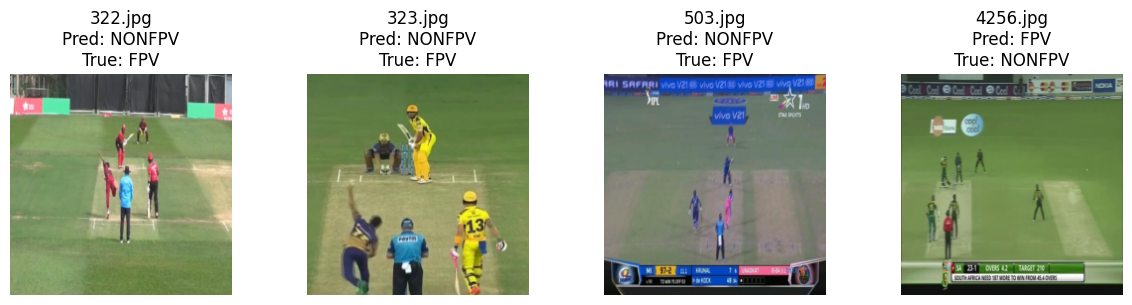

In [2]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import torch
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandAugment

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import CosineAnnealingLR

import torchmetrics
import timm
!pip -q install split-folders
import splitfolders

# =========================
# Setup
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.manual_seed(42)
np.random.seed(42)

# Hyperparameters
batch_size = 48
img_height, img_width = 224, 224
learning_rate = 2e-4
epochs = 20

# =========================
# Dataset Split
# =========================
# os.makedirs('/kaggle/working/Cricket', exist_ok=True)
# splitfolders.ratio(
#     '/kaggle/input/fpv-dataset/Hybrid_Dataset',
#     output='/kaggle/working/Cricket',
#     seed=42,
#     ratio=(.5, .0, .5),  # train, val, test
#     move=False
# )

# =========================
# DataModule
# =========================
class FireDataModule(pl.LightningDataModule):
    def __init__(self, path="/kaggle/working/Cricket"):
        super().__init__()
        self.PATH = path

    def setup(self, stage=None):
        train_transform = Compose([
            Resize((img_height, img_width)),
            RandAugment(num_ops=2, magnitude=9),
            ToTensor(),
            Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        test_transform = Compose([
            Resize((img_height, img_width)),
            ToTensor(),
            Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        if stage in ("fit", None):
            self.train = datasets.ImageFolder(os.path.join(self.PATH, 'train'), transform=train_transform)
            #self.val = datasets.ImageFolder(os.path.join(self.PATH, 'val'), transform=test_transform)
        if stage in ("test", None):
            self.test = datasets.ImageFolder(os.path.join(self.PATH, 'test'), transform=test_transform)

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=batch_size, shuffle=True, num_workers=2)

    #def val_dataloader(self):
       # return DataLoader(self.val, batch_size=batch_size, num_workers=2)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=batch_size, num_workers=2)

# =========================
# Model
# =========================
class PretrainedMobileNetV3(pl.LightningModule):
    def __init__(self, learning_rate=2e-4):
        super().__init__()
        self.save_hyperparameters()
        # Binary classification -> output 1 logit
        self.model = timm.create_model("mobilenetv3_small_100", pretrained=True, num_classes=1)

        # 🔒 Freeze block 2 and block 4
        for idx in [0,3,5]:
            for param in self.model.blocks[idx].parameters():
                param.requires_grad = False

        self.train_acc = torchmetrics.Accuracy(task="binary")
        #self.val_acc = torchmetrics.Accuracy(task="binary")
        self.test_acc = torchmetrics.Accuracy(task="binary")
        self.test_precision = torchmetrics.Precision(task="binary", average='macro')
        self.test_recall = torchmetrics.Recall(task="binary", average='macro')
        self.test_f1 = torchmetrics.F1Score(task="binary", average='macro')

    def forward(self, x):
        return self.model(x).squeeze(1)  # shape: [B]

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        acc = self.train_acc(preds, y.int())
        self.log("train_loss", loss, on_epoch=True)
        self.log("train_acc", acc, on_epoch=True)
        return loss

    # def validation_step(self, batch, batch_idx):
    #     x, y = batch
    #     y = y.float()
    #     logits = self(x)
    #     loss = F.binary_cross_entropy_with_logits(logits, y)
    #     preds = torch.sigmoid(logits)
    #     acc = self.val_acc(preds, y.int())
    #     self.log("val_loss", loss, on_epoch=True, prog_bar=True)
    #     self.log("val_acc", acc, on_epoch=True, prog_bar=True)
    #     return {"val_loss": loss, "val_acc": acc}

    def on_train_epoch_end(self):
        train_loss = self.trainer.callback_metrics.get("train_loss")
        train_acc = self.trainer.callback_metrics.get("train_acc")
        # val_loss = self.trainer.callback_metrics.get("val_loss")
        # val_acc = self.trainer.callback_metrics.get("val_acc")
        print(f"Epoch {self.current_epoch + 1}: "
              f"[Train] Loss: {train_loss:.4f} | Acc: {train_acc:.4f} ")

    def test_step(self, batch, _):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        self.test_acc(preds, y.int())
        self.test_precision(preds, y.int())
        self.test_recall(preds, y.int())
        self.test_f1(preds, y.int())
        self.log_dict({
            "test_loss": loss,
            "test_acc": self.test_acc,
            "test_precision": self.test_precision,
            "test_recall": self.test_recall,
            "test_f1": self.test_f1
        }, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.learning_rate, weight_decay=0.05)
        scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

# =========================
# Dataset Stats
# =========================
def print_dataset_statistics(data_module):
    train_dataset = data_module.train
    # val_dataset = data_module.val
    test_dataset = data_module.test

    def count_per_class(dataset):
        counts = {cls: 0 for cls in dataset.classes}
        for _, label in dataset.samples:
            counts[dataset.classes[label]] += 1
        return counts

    print("\n========== Dataset Statistics ==========")
    print(f"Classes: {train_dataset.classes}")
    print(f"Total Training Samples: {len(train_dataset)} | {count_per_class(train_dataset)}")
    # print(f"Total Validation Samples: {len(val_dataset)} | {count_per_class(val_dataset)}")
    print(f"Total Testing Samples: {len(test_dataset)} | {count_per_class(test_dataset)}")
    print(f"Total Samples : {len(train_dataset)+len(test_dataset)}")
    print("========================================\n")

# =========================
# Training
# =========================
data_module = FireDataModule()
data_module.setup()
print_dataset_statistics(data_module)

mobilenet_model = PretrainedMobileNetV3()

callbacks = [
    ModelCheckpoint(monitor="train_loss", dirpath="/kaggle/working/mobilenetv3",
                    filename="mobilenetv3-{epoch:02d}-{val_loss:.5f}", save_top_k=1, mode="min"),
    EarlyStopping(monitor="train_loss", patience=3, mode="min"),
    LearningRateMonitor(logging_interval='epoch')
]

logger = CSVLogger(save_dir="/kaggle/working/mobilenetv3", name="mobilenetv3_logs")

trainer = pl.Trainer(
    max_epochs=epochs,
    accelerator="auto",
    callbacks=callbacks,
    logger=logger,
    log_every_n_steps=1
)

start = time.time()
trainer.fit(mobilenet_model, datamodule=data_module)
end = time.time()
print(f"\nTotal Training Time: {int((end - start) // 60)} min")

# =========================
# Evaluation
# =========================
def evaluate_model(model, data_module):
    model.eval().to(device)
    all_preds, all_labels, misclassified_images = [], [], []
    test_loader = data_module.test_dataloader()
    start_time = time.time()
    total_images = 0
    sample_paths = test_loader.dataset.samples

    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = torch.sigmoid(logits)
            preds_label = (preds > 0.5).long()
            all_preds.extend(preds_label.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

            batch_paths = [sample_paths[i][0] for i in range(batch_idx * test_loader.batch_size,
                                                            batch_idx * test_loader.batch_size + len(y))]
            for i in range(len(y)):
                if preds_label[i] != y[i]:
                    misclassified_images.append((
                        x[i].cpu(),
                        preds_label[i].item(),
                        y[i].item(),
                        batch_paths[i]
                    ))
            total_images += x.size(0)

    elapsed_time = time.time() - start_time
    fps = total_images / elapsed_time
    avg_time_per_image = elapsed_time / total_images

    print(f"\nInference Performance:")
    print(f"Total images:         {total_images}")
    print(f"Total inference time: {elapsed_time:.2f} seconds")
    print(f"Average FPS:          {fps:.2f} images/second")
    print(f"Avg time/image:       {avg_time_per_image:.4f} seconds")

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(cm, display_labels=test_loader.dataset.classes)
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()


    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4, target_names=test_loader.dataset.classes))

    if misclassified_images:
        print(f"\nShowing {len(misclassified_images)} misclassified images:")
        class_names = test_loader.dataset.classes
        cols = 5
        rows = (len(misclassified_images) + cols - 1) // cols
        plt.figure(figsize=(cols * 3, rows * 3))
        for idx, (img_tensor, pred, true, file_path) in enumerate(misclassified_images):
            img = img_tensor.permute(1, 2, 0).numpy()
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img = np.clip(img, 0, 1)
            plt.subplot(rows, cols, idx + 1)
            plt.imshow(img)
            filename = file_path.split("/")[-1]
            plt.title(f"{filename}\nPred: {class_names[pred]}\nTrue: {class_names[true]}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("\nNo misclassified images found.")

mobilenet_model.to(device)
evaluate_model(mobilenet_model, data_module)


Using device: cuda

========== Dataset Statistics ==========
Classes: ['FPV', 'NONFPV']
Total Training Samples: 6300 | {'FPV': 3150, 'NONFPV': 3150}
Total Validation Samples: 1260 | {'FPV': 630, 'NONFPV': 630}
Total Testing Samples: 5040 | {'FPV': 2520, 'NONFPV': 2520}
Total Samples : 12600



/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /kaggle/working/mobilenetv3 exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: [Train] Loss: 0.2660 | Acc: 0.9646 || [Val] Loss: 0.0090 | Acc: 0.9960


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: [Train] Loss: 0.0597 | Acc: 0.9881 || [Val] Loss: 0.0150 | Acc: 0.9944


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: [Train] Loss: 0.0506 | Acc: 0.9894 || [Val] Loss: 0.0586 | Acc: 0.9889


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: [Train] Loss: 0.0255 | Acc: 0.9943 || [Val] Loss: 0.0193 | Acc: 0.9952

Total Training Time: 4 min

Inference Performance:
Total images:         5040
Total inference time: 40.64 seconds
Average FPS:          124.00 images/second
Avg time/image:       0.0081 seconds


<Figure size 600x500 with 0 Axes>

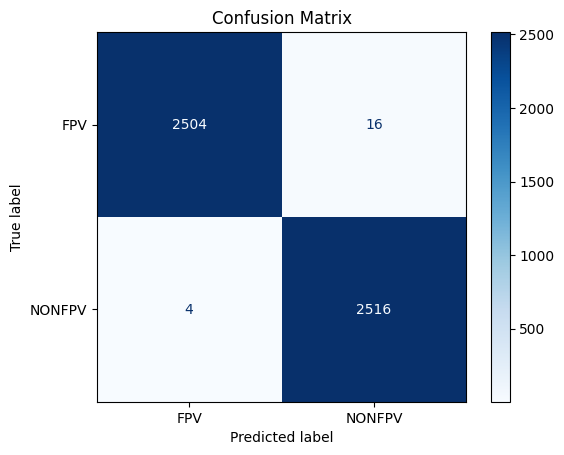


Classification Report:
              precision    recall  f1-score   support

         FPV     0.9984    0.9937    0.9960      2520
      NONFPV     0.9937    0.9984    0.9960      2520

    accuracy                         0.9960      5040
   macro avg     0.9960    0.9960    0.9960      5040
weighted avg     0.9960    0.9960    0.9960      5040


Showing 20 misclassified images:


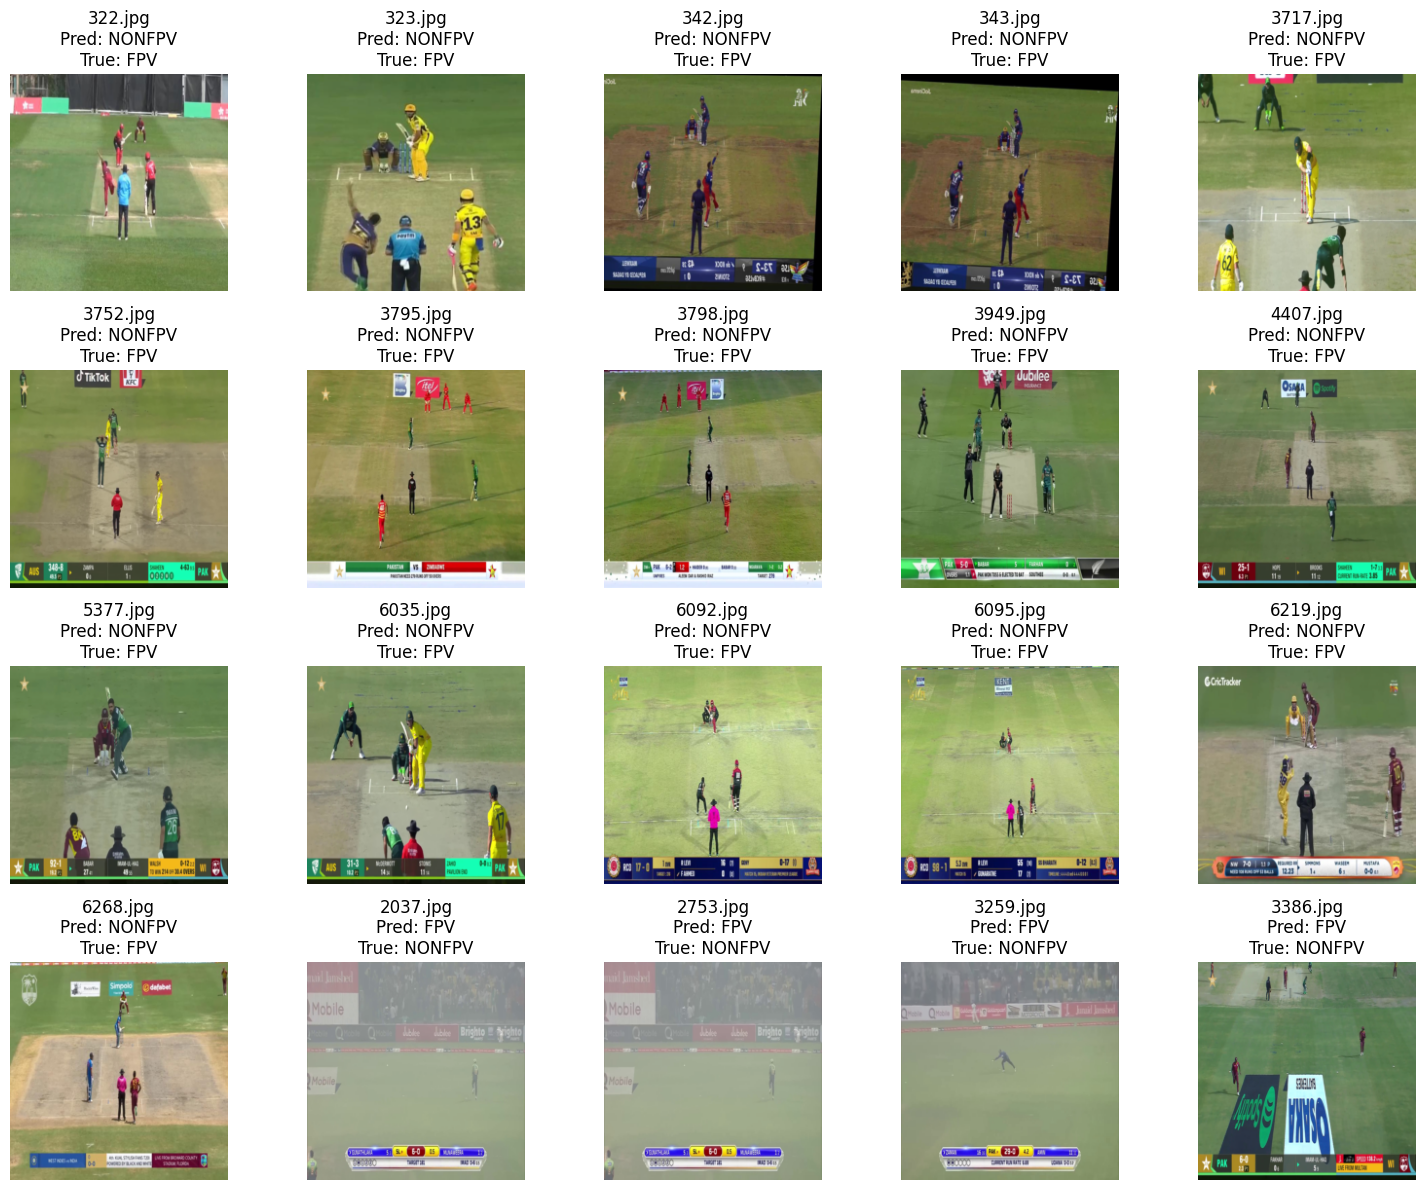

In [8]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import torch
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandAugment

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import CosineAnnealingLR

import torchmetrics
import timm
!pip -q install split-folders
import splitfolders

# =========================
# Setup
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.manual_seed(42)
np.random.seed(42)

# Hyperparameters
batch_size = 48
img_height, img_width = 224, 224
learning_rate = 2e-4
epochs = 20

# =========================
# Dataset Split
# =========================
# os.makedirs('/kaggle/working/Cricket', exist_ok=True)
# splitfolders.ratio(
#     '/kaggle/input/fpv-dataset/Hybrid_Dataset',
#     output='/kaggle/working/Cricket',
#     seed=42,
#     ratio=(.5, .1, .4),  # train, val, test
#     move=False
# )

# =========================
# DataModule
# =========================
class FireDataModule(pl.LightningDataModule):
    def __init__(self, path="/kaggle/working/Cricket"):
        super().__init__()
        self.PATH = path

    def setup(self, stage=None):
        train_transform = Compose([
            Resize((img_height, img_width)),
            RandAugment(num_ops=2, magnitude=9),
            ToTensor(),
            Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        test_transform = Compose([
            Resize((img_height, img_width)),
            ToTensor(),
            Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        if stage in ("fit", None):
            self.train = datasets.ImageFolder(os.path.join(self.PATH, 'train'), transform=train_transform)
            self.val = datasets.ImageFolder(os.path.join(self.PATH, 'val'), transform=test_transform)
        if stage in ("test", None):
            self.test = datasets.ImageFolder(os.path.join(self.PATH, 'test'), transform=test_transform)

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=batch_size, num_workers=2)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=batch_size, num_workers=2)

# =========================
# Model
# =========================
class PretrainedMobileNetV3(pl.LightningModule):
    def __init__(self, learning_rate=2e-4):
        super().__init__()
        self.save_hyperparameters()
        # Binary classification -> output 1 logit
        self.model = timm.create_model("mobilenetv3_small_100", pretrained=True, num_classes=1)

        # 🔒 Freeze block 2 and block 4
        for idx in [3,2,1]:
            for param in self.model.blocks[idx].parameters():
                param.requires_grad = False

        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.val_acc = torchmetrics.Accuracy(task="binary")
        self.test_acc = torchmetrics.Accuracy(task="binary")
        self.test_precision = torchmetrics.Precision(task="binary", average='macro')
        self.test_recall = torchmetrics.Recall(task="binary", average='macro')
        self.test_f1 = torchmetrics.F1Score(task="binary", average='macro')

    def forward(self, x):
        return self.model(x).squeeze(1)  # shape: [B]

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        acc = self.train_acc(preds, y.int())
        self.log("train_loss", loss, on_epoch=True)
        self.log("train_acc", acc, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        acc = self.val_acc(preds, y.int())
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True)
        return {"val_loss": loss, "val_acc": acc}

    def on_train_epoch_end(self):
        train_loss = self.trainer.callback_metrics.get("train_loss")
        train_acc = self.trainer.callback_metrics.get("train_acc")
        val_loss = self.trainer.callback_metrics.get("val_loss")
        val_acc = self.trainer.callback_metrics.get("val_acc")
        print(f"Epoch {self.current_epoch + 1}: "
              f"[Train] Loss: {train_loss:.4f} | Acc: {train_acc:.4f} || "
              f"[Val] Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    def test_step(self, batch, _):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        self.test_acc(preds, y.int())
        self.test_precision(preds, y.int())
        self.test_recall(preds, y.int())
        self.test_f1(preds, y.int())
        self.log_dict({
            "test_loss": loss,
            "test_acc": self.test_acc,
            "test_precision": self.test_precision,
            "test_recall": self.test_recall,
            "test_f1": self.test_f1
        }, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.learning_rate, weight_decay=0.05)
        scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

# =========================
# Dataset Stats
# =========================
def print_dataset_statistics(data_module):
    train_dataset = data_module.train
    val_dataset = data_module.val
    test_dataset = data_module.test

    def count_per_class(dataset):
        counts = {cls: 0 for cls in dataset.classes}
        for _, label in dataset.samples:
            counts[dataset.classes[label]] += 1
        return counts

    print("\n========== Dataset Statistics ==========")
    print(f"Classes: {train_dataset.classes}")
    print(f"Total Training Samples: {len(train_dataset)} | {count_per_class(train_dataset)}")
    print(f"Total Validation Samples: {len(val_dataset)} | {count_per_class(val_dataset)}")
    print(f"Total Testing Samples: {len(test_dataset)} | {count_per_class(test_dataset)}")
    print(f"Total Samples : {len(train_dataset)+len(val_dataset)+len(test_dataset)}")
    print("========================================\n")

# =========================
# Training
# =========================
data_module = FireDataModule()
data_module.setup()
print_dataset_statistics(data_module)

mobilenet_model = PretrainedMobileNetV3()

callbacks = [
    ModelCheckpoint(monitor="val_loss", dirpath="/kaggle/working/mobilenetv3",
                    filename="mobilenetv3-{epoch:02d}-{val_loss:.5f}", save_top_k=1, mode="min"),
    EarlyStopping(monitor="val_loss", patience=3, mode="min"),
    LearningRateMonitor(logging_interval='epoch')
]

logger = CSVLogger(save_dir="/kaggle/working/mobilenetv3", name="mobilenetv3_logs")

trainer = pl.Trainer(
    max_epochs=epochs,
    accelerator="auto",
    callbacks=callbacks,
    logger=logger,
    log_every_n_steps=1
)

start = time.time()
trainer.fit(mobilenet_model, datamodule=data_module)
end = time.time()
print(f"\nTotal Training Time: {int((end - start) // 60)} min")

# =========================
# Evaluation
# =========================
def evaluate_model(model, data_module):
    model.eval().to(device)
    all_preds, all_labels, misclassified_images = [], [], []
    test_loader = data_module.test_dataloader()
    start_time = time.time()
    total_images = 0
    sample_paths = test_loader.dataset.samples

    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = torch.sigmoid(logits)
            preds_label = (preds > 0.5).long()
            all_preds.extend(preds_label.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

            batch_paths = [sample_paths[i][0] for i in range(batch_idx * test_loader.batch_size,
                                                            batch_idx * test_loader.batch_size + len(y))]
            for i in range(len(y)):
                if preds_label[i] != y[i]:
                    misclassified_images.append((
                        x[i].cpu(),
                        preds_label[i].item(),
                        y[i].item(),
                        batch_paths[i]
                    ))
            total_images += x.size(0)

    elapsed_time = time.time() - start_time
    fps = total_images / elapsed_time
    avg_time_per_image = elapsed_time / total_images

    print(f"\nInference Performance:")
    print(f"Total images:         {total_images}")
    print(f"Total inference time: {elapsed_time:.2f} seconds")
    print(f"Average FPS:          {fps:.2f} images/second")
    print(f"Avg time/image:       {avg_time_per_image:.4f} seconds")

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(cm, display_labels=test_loader.dataset.classes)
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()


    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4, target_names=test_loader.dataset.classes))

    if misclassified_images:
        print(f"\nShowing {len(misclassified_images)} misclassified images:")
        class_names = test_loader.dataset.classes
        cols = 5
        rows = (len(misclassified_images) + cols - 1) // cols
        plt.figure(figsize=(cols * 3, rows * 3))
        for idx, (img_tensor, pred, true, file_path) in enumerate(misclassified_images):
            img = img_tensor.permute(1, 2, 0).numpy()
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img = np.clip(img, 0, 1)
            plt.subplot(rows, cols, idx + 1)
            plt.imshow(img)
            filename = file_path.split("/")[-1]
            plt.title(f"{filename}\nPred: {class_names[pred]}\nTrue: {class_names[true]}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("\nNo misclassified images found.")

mobilenet_model.to(device)
evaluate_model(mobilenet_model, data_module)

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import torch
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandAugment

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import CosineAnnealingLR

import torchmetrics
import timm
!pip -q install split-folders
import splitfolders

# =========================
# Setup
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.manual_seed(42)
np.random.seed(42)

# Hyperparameters
batch_size = 48
img_height, img_width = 224, 224
learning_rate = 2e-4
epochs = 20

# =========================
# Dataset Split
# =========================
# os.makedirs('/kaggle/working/Cricket', exist_ok=True)
# splitfolders.ratio(
#     '/kaggle/input/fpv-dataset/Hybrid_Dataset',
#     output='/kaggle/working/Cricket',
#     seed=42,
#     ratio=(.5, .1, .4),  # train, val, test
#     move=False
# )


# =========================
# Model
# =========================
class PretrainedMobileNetV3(pl.LightningModule):
    def __init__(self, learning_rate=2e-4):
        super().__init__()
        self.save_hyperparameters()
        # Binary classification -> output 1 logit
        self.model = timm.create_model("mobilenetv3_small_100", pretrained=True, num_classes=1)

        # 🔒 Freeze block 2 and block 4
        for idx in [3,2,1]:
            for param in self.model.blocks[idx].parameters():
                param.requires_grad = False

        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.val_acc = torchmetrics.Accuracy(task="binary")
        self.test_acc = torchmetrics.Accuracy(task="binary")
        self.test_precision = torchmetrics.Precision(task="binary", average='macro')
        self.test_recall = torchmetrics.Recall(task="binary", average='macro')
        self.test_f1 = torchmetrics.F1Score(task="binary", average='macro')

    def forward(self, x):
        return self.model(x).squeeze(1)  # shape: [B]

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        acc = self.train_acc(preds, y.int())
        self.log("train_loss", loss, on_epoch=True)
        self.log("train_acc", acc, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        acc = self.val_acc(preds, y.int())
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True)
        return {"val_loss": loss, "val_acc": acc}

    def on_train_epoch_end(self):
        train_loss = self.trainer.callback_metrics.get("train_loss")
        train_acc = self.trainer.callback_metrics.get("train_acc")
        val_loss = self.trainer.callback_metrics.get("val_loss")
        val_acc = self.trainer.callback_metrics.get("val_acc")
        print(f"Epoch {self.current_epoch + 1}: "
              f"[Train] Loss: {train_loss:.4f} | Acc: {train_acc:.4f} || "
              f"[Val] Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    def test_step(self, batch, _):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        self.test_acc(preds, y.int())
        self.test_precision(preds, y.int())
        self.test_recall(preds, y.int())
        self.test_f1(preds, y.int())
        self.log_dict({
            "test_loss": loss,
            "test_acc": self.test_acc,
            "test_precision": self.test_precision,
            "test_recall": self.test_recall,
            "test_f1": self.test_f1
        }, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.learning_rate, weight_decay=0.05)
        scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

# mobilenet_model = PretrainedMobileNetV3()
from torchinfo import summary
import torch

x = torch.randn(1, 3, 224, 224)

model_small = PretrainedMobileNetV3()

print("\n--- MobileNetV3 Small (full detail) ---")
summary(
    model_small, 
    input_size=(1, 3, 224, 224), 
    depth=4,           # traverse all layers recursively
    col_names=("input_size", "output_size", "num_params", "trainable")
)


Using device: cuda


model.safetensors:   0%|          | 0.00/10.2M [00:00<?, ?B/s]


--- MobileNetV3 Small (full detail) ---


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
PretrainedMobileNetV3                              [1, 3, 224, 224]          [1]                       --                        Partial
├─MobileNetV3: 1-1                                 [1, 3, 224, 224]          [1, 1]                    --                        Partial
│    └─Conv2d: 2-1                                 [1, 3, 224, 224]          [1, 16, 112, 112]         432                       True
│    └─BatchNormAct2d: 2-2                         [1, 16, 112, 112]         [1, 16, 112, 112]         32                        True
│    │    └─Identity: 3-1                          [1, 16, 112, 112]         [1, 16, 112, 112]         --                        --
│    │    └─Hardswish: 3-2                         [1, 16, 112, 112]         [1, 16, 112, 112]         --                        --
│    └─Sequential: 2-3                             [1, 

Using device: cuda

========== Dataset Statistics ==========
Classes: ['FPV', 'NONFPV']
Total Training Samples: 6300 | {'FPV': 3150, 'NONFPV': 3150}
Total Validation Samples: 1260 | {'FPV': 630, 'NONFPV': 630}
Total Testing Samples: 5040 | {'FPV': 2520, 'NONFPV': 2520}
Total Samples : 12600



/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /kaggle/working/mobilenetv3 exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: [Train] Loss: 0.2294 | Acc: 0.9673 || [Val] Loss: 0.0048 | Acc: 0.9976


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: [Train] Loss: 0.0559 | Acc: 0.9895 || [Val] Loss: 0.0134 | Acc: 0.9960


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: [Train] Loss: 0.0256 | Acc: 0.9944 || [Val] Loss: 0.0069 | Acc: 0.9968


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: [Train] Loss: 0.0174 | Acc: 0.9956 || [Val] Loss: 0.0204 | Acc: 0.9944

Total Training Time: 4 min

Inference Performance:
Total images:         5040
Total inference time: 40.90 seconds
Average FPS:          123.22 images/second
Avg time/image:       0.0081 seconds


<Figure size 600x500 with 0 Axes>

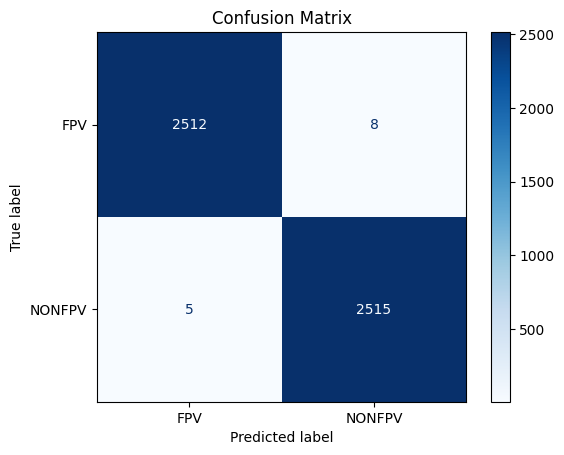


Classification Report:
              precision    recall  f1-score   support

         FPV     0.9980    0.9968    0.9974      2520
      NONFPV     0.9968    0.9980    0.9974      2520

    accuracy                         0.9974      5040
   macro avg     0.9974    0.9974    0.9974      5040
weighted avg     0.9974    0.9974    0.9974      5040


Showing 13 misclassified images:


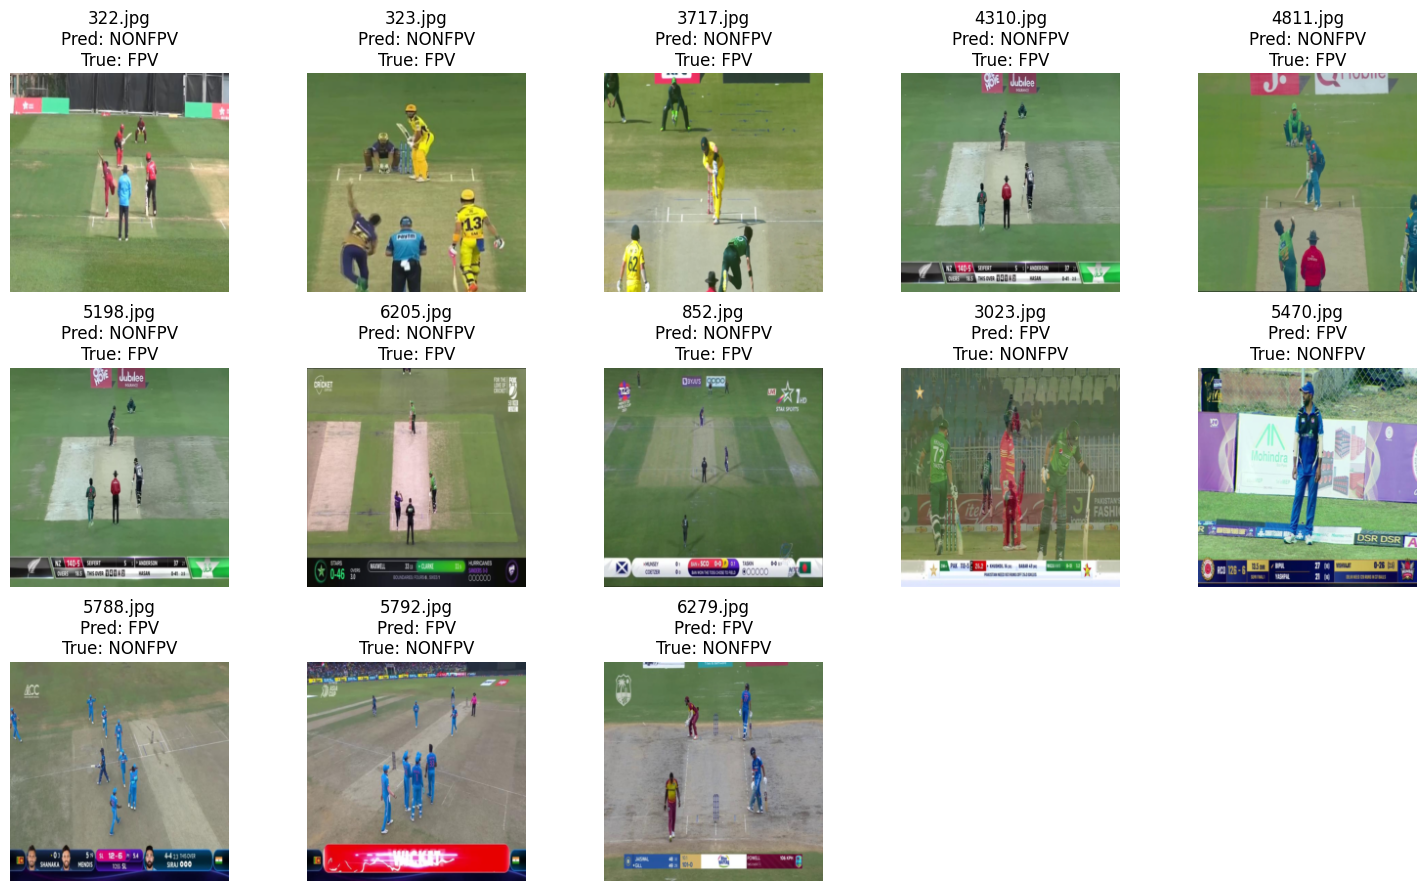

In [9]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import torch
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandAugment

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import CosineAnnealingLR

import torchmetrics
import timm
!pip -q install split-folders
import splitfolders

# =========================
# Setup
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.manual_seed(42)
np.random.seed(42)

# Hyperparameters
batch_size = 48
img_height, img_width = 224, 224
learning_rate = 2e-4
epochs = 20

# =========================
# Dataset Split
# =========================
# os.makedirs('/kaggle/working/Cricket', exist_ok=True)
# splitfolders.ratio(
#     '/kaggle/input/fpv-dataset/Hybrid_Dataset',
#     output='/kaggle/working/Cricket',
#     seed=42,
#     ratio=(.5, .1, .4),  # train, val, test
#     move=False
# )

# =========================
# DataModule
# =========================
class FireDataModule(pl.LightningDataModule):
    def __init__(self, path="/kaggle/working/Cricket"):
        super().__init__()
        self.PATH = path

    def setup(self, stage=None):
        train_transform = Compose([
            Resize((img_height, img_width)),
            RandAugment(num_ops=2, magnitude=9),
            ToTensor(),
            Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        test_transform = Compose([
            Resize((img_height, img_width)),
            ToTensor(),
            Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        if stage in ("fit", None):
            self.train = datasets.ImageFolder(os.path.join(self.PATH, 'train'), transform=train_transform)
            self.val = datasets.ImageFolder(os.path.join(self.PATH, 'val'), transform=test_transform)
        if stage in ("test", None):
            self.test = datasets.ImageFolder(os.path.join(self.PATH, 'test'), transform=test_transform)

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=batch_size, num_workers=2)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=batch_size, num_workers=2)

# =========================
# Model
# =========================
class PretrainedMobileNetV3(pl.LightningModule):
    def __init__(self, learning_rate=2e-4):
        super().__init__()
        self.save_hyperparameters()
        # Binary classification -> output 1 logit
        self.model = timm.create_model("mobilenetv3_small_100", pretrained=True, num_classes=1)

        # 🔒 Freeze block 2 and block 4
        for idx in [0,3,5]:
            for param in self.model.blocks[idx].parameters():
                param.requires_grad = False

        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.val_acc = torchmetrics.Accuracy(task="binary")
        self.test_acc = torchmetrics.Accuracy(task="binary")
        self.test_precision = torchmetrics.Precision(task="binary", average='macro')
        self.test_recall = torchmetrics.Recall(task="binary", average='macro')
        self.test_f1 = torchmetrics.F1Score(task="binary", average='macro')

    def forward(self, x):
        return self.model(x).squeeze(1)  # shape: [B]

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        acc = self.train_acc(preds, y.int())
        self.log("train_loss", loss, on_epoch=True)
        self.log("train_acc", acc, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        acc = self.val_acc(preds, y.int())
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True)
        return {"val_loss": loss, "val_acc": acc}

    def on_train_epoch_end(self):
        train_loss = self.trainer.callback_metrics.get("train_loss")
        train_acc = self.trainer.callback_metrics.get("train_acc")
        val_loss = self.trainer.callback_metrics.get("val_loss")
        val_acc = self.trainer.callback_metrics.get("val_acc")
        print(f"Epoch {self.current_epoch + 1}: "
              f"[Train] Loss: {train_loss:.4f} | Acc: {train_acc:.4f} || "
              f"[Val] Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    def test_step(self, batch, _):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        self.test_acc(preds, y.int())
        self.test_precision(preds, y.int())
        self.test_recall(preds, y.int())
        self.test_f1(preds, y.int())
        self.log_dict({
            "test_loss": loss,
            "test_acc": self.test_acc,
            "test_precision": self.test_precision,
            "test_recall": self.test_recall,
            "test_f1": self.test_f1
        }, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.learning_rate, weight_decay=0.05)
        scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

# =========================
# Dataset Stats
# =========================
def print_dataset_statistics(data_module):
    train_dataset = data_module.train
    val_dataset = data_module.val
    test_dataset = data_module.test

    def count_per_class(dataset):
        counts = {cls: 0 for cls in dataset.classes}
        for _, label in dataset.samples:
            counts[dataset.classes[label]] += 1
        return counts

    print("\n========== Dataset Statistics ==========")
    print(f"Classes: {train_dataset.classes}")
    print(f"Total Training Samples: {len(train_dataset)} | {count_per_class(train_dataset)}")
    print(f"Total Validation Samples: {len(val_dataset)} | {count_per_class(val_dataset)}")
    print(f"Total Testing Samples: {len(test_dataset)} | {count_per_class(test_dataset)}")
    print(f"Total Samples : {len(train_dataset)+len(val_dataset)+len(test_dataset)}")
    print("========================================\n")

# =========================
# Training
# =========================
data_module = FireDataModule()
data_module.setup()
print_dataset_statistics(data_module)

mobilenet_model = PretrainedMobileNetV3()

callbacks = [
    ModelCheckpoint(monitor="val_loss", dirpath="/kaggle/working/mobilenetv3",
                    filename="mobilenetv3-{epoch:02d}-{val_loss:.5f}", save_top_k=1, mode="min"),
    EarlyStopping(monitor="val_loss", patience=3, mode="min"),
    LearningRateMonitor(logging_interval='epoch')
]

logger = CSVLogger(save_dir="/kaggle/working/mobilenetv3", name="mobilenetv3_logs")

trainer = pl.Trainer(
    max_epochs=epochs,
    accelerator="auto",
    callbacks=callbacks,
    logger=logger,
    log_every_n_steps=1
)

start = time.time()
trainer.fit(mobilenet_model, datamodule=data_module)
end = time.time()
print(f"\nTotal Training Time: {int((end - start) // 60)} min")

# =========================
# Evaluation
# =========================
def evaluate_model(model, data_module):
    model.eval().to(device)
    all_preds, all_labels, misclassified_images = [], [], []
    test_loader = data_module.test_dataloader()
    start_time = time.time()
    total_images = 0
    sample_paths = test_loader.dataset.samples

    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = torch.sigmoid(logits)
            preds_label = (preds > 0.5).long()
            all_preds.extend(preds_label.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

            batch_paths = [sample_paths[i][0] for i in range(batch_idx * test_loader.batch_size,
                                                            batch_idx * test_loader.batch_size + len(y))]
            for i in range(len(y)):
                if preds_label[i] != y[i]:
                    misclassified_images.append((
                        x[i].cpu(),
                        preds_label[i].item(),
                        y[i].item(),
                        batch_paths[i]
                    ))
            total_images += x.size(0)

    elapsed_time = time.time() - start_time
    fps = total_images / elapsed_time
    avg_time_per_image = elapsed_time / total_images

    print(f"\nInference Performance:")
    print(f"Total images:         {total_images}")
    print(f"Total inference time: {elapsed_time:.2f} seconds")
    print(f"Average FPS:          {fps:.2f} images/second")
    print(f"Avg time/image:       {avg_time_per_image:.4f} seconds")

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(cm, display_labels=test_loader.dataset.classes)
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()


    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4, target_names=test_loader.dataset.classes))

    if misclassified_images:
        print(f"\nShowing {len(misclassified_images)} misclassified images:")
        class_names = test_loader.dataset.classes
        cols = 5
        rows = (len(misclassified_images) + cols - 1) // cols
        plt.figure(figsize=(cols * 3, rows * 3))
        for idx, (img_tensor, pred, true, file_path) in enumerate(misclassified_images):
            img = img_tensor.permute(1, 2, 0).numpy()
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img = np.clip(img, 0, 1)
            plt.subplot(rows, cols, idx + 1)
            plt.imshow(img)
            filename = file_path.split("/")[-1]
            plt.title(f"{filename}\nPred: {class_names[pred]}\nTrue: {class_names[true]}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("\nNo misclassified images found.")

mobilenet_model.to(device)
evaluate_model(mobilenet_model, data_module)


In [2]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import torch
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandAugment

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import CosineAnnealingLR

import torchmetrics
import timm
!pip -q install split-folders
import splitfolders

# =========================
# Setup
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.manual_seed(42)
np.random.seed(42)

# Hyperparameters
batch_size = 48
img_height, img_width = 224, 224
learning_rate = 2e-4
epochs = 20

# =========================
# Dataset Split
# =========================
# os.makedirs('/kaggle/working/Cricket', exist_ok=True)
# splitfolders.ratio(
#     '/kaggle/input/fpv-dataset/Hybrid_Dataset',
#     output='/kaggle/working/Cricket',
#     seed=42,
#     ratio=(.5, .1, .4),  # train, val, test
#     move=False
# )


# =========================
# Model
# =========================
class PretrainedMobileNetV3(pl.LightningModule):
    def __init__(self, learning_rate=2e-4):
        super().__init__()
        self.save_hyperparameters()
        # Binary classification -> output 1 logit
        self.model = timm.create_model("mobilenetv3_small_100", pretrained=True, num_classes=1)

        # 🔒 Freeze block 2 and block 4
        for idx in [0,3,5]:
            for param in self.model.blocks[idx].parameters():
                param.requires_grad = False

        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.val_acc = torchmetrics.Accuracy(task="binary")
        self.test_acc = torchmetrics.Accuracy(task="binary")
        self.test_precision = torchmetrics.Precision(task="binary", average='macro')
        self.test_recall = torchmetrics.Recall(task="binary", average='macro')
        self.test_f1 = torchmetrics.F1Score(task="binary", average='macro')

    def forward(self, x):
        return self.model(x).squeeze(1)  # shape: [B]

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        acc = self.train_acc(preds, y.int())
        self.log("train_loss", loss, on_epoch=True)
        self.log("train_acc", acc, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        acc = self.val_acc(preds, y.int())
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True)
        return {"val_loss": loss, "val_acc": acc}

    def on_train_epoch_end(self):
        train_loss = self.trainer.callback_metrics.get("train_loss")
        train_acc = self.trainer.callback_metrics.get("train_acc")
        val_loss = self.trainer.callback_metrics.get("val_loss")
        val_acc = self.trainer.callback_metrics.get("val_acc")
        print(f"Epoch {self.current_epoch + 1}: "
              f"[Train] Loss: {train_loss:.4f} | Acc: {train_acc:.4f} || "
              f"[Val] Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    def test_step(self, batch, _):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        self.test_acc(preds, y.int())
        self.test_precision(preds, y.int())
        self.test_recall(preds, y.int())
        self.test_f1(preds, y.int())
        self.log_dict({
            "test_loss": loss,
            "test_acc": self.test_acc,
            "test_precision": self.test_precision,
            "test_recall": self.test_recall,
            "test_f1": self.test_f1
        }, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.learning_rate, weight_decay=0.05)
        scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

# mobilenet_model = PretrainedMobileNetV3()
from torchinfo import summary
import torch

x = torch.randn(1, 3, 224, 224)

model_small = PretrainedMobileNetV3()

print("\n--- MobileNetV3 Small (full detail) ---")
summary(
    model_small, 
    input_size=(1, 3, 224, 224), 
    depth=4,           # traverse all layers recursively
    col_names=("input_size", "output_size", "num_params", "trainable")
)


Using device: cuda

--- MobileNetV3 Small (full detail) ---


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
PretrainedMobileNetV3                              [1, 3, 224, 224]          [1]                       --                        Partial
├─MobileNetV3: 1-1                                 [1, 3, 224, 224]          [1, 1]                    --                        Partial
│    └─Conv2d: 2-1                                 [1, 3, 224, 224]          [1, 16, 112, 112]         432                       True
│    └─BatchNormAct2d: 2-2                         [1, 16, 112, 112]         [1, 16, 112, 112]         32                        True
│    │    └─Identity: 3-1                          [1, 16, 112, 112]         [1, 16, 112, 112]         --                        --
│    │    └─Hardswish: 3-2                         [1, 16, 112, 112]         [1, 16, 112, 112]         --                        --
│    └─Sequential: 2-3                             [1, 

Using device: cuda

========== Dataset Statistics ==========
Classes: ['FPV', 'NONFPV']
Total Training Samples: 6300 | {'FPV': 3150, 'NONFPV': 3150}
Total Validation Samples: 1260 | {'FPV': 630, 'NONFPV': 630}
Total Testing Samples: 5040 | {'FPV': 2520, 'NONFPV': 2520}
Total Samples : 12600



/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /kaggle/working/mobilenetv3 exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: [Train] Loss: 0.2528 | Acc: 0.9675 || [Val] Loss: 0.1317 | Acc: 0.9778


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: [Train] Loss: 0.0417 | Acc: 0.9922 || [Val] Loss: 0.0421 | Acc: 0.9905


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: [Train] Loss: 0.0185 | Acc: 0.9949 || [Val] Loss: 0.0130 | Acc: 0.9960


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: [Train] Loss: 0.0179 | Acc: 0.9948 || [Val] Loss: 0.0092 | Acc: 0.9968


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: [Train] Loss: 0.0103 | Acc: 0.9970 || [Val] Loss: 0.0038 | Acc: 0.9968


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: [Train] Loss: 0.0210 | Acc: 0.9951 || [Val] Loss: 0.0027 | Acc: 0.9992


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: [Train] Loss: 0.0175 | Acc: 0.9949 || [Val] Loss: 0.0133 | Acc: 0.9968


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: [Train] Loss: 0.0122 | Acc: 0.9973 || [Val] Loss: 0.0440 | Acc: 0.9952


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: [Train] Loss: 0.0120 | Acc: 0.9971 || [Val] Loss: 0.0024 | Acc: 0.9992


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: [Train] Loss: 0.0059 | Acc: 0.9983 || [Val] Loss: 0.0167 | Acc: 0.9968


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: [Train] Loss: 0.0025 | Acc: 0.9992 || [Val] Loss: 0.0120 | Acc: 0.9976


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: [Train] Loss: 0.0017 | Acc: 0.9992 || [Val] Loss: 0.0018 | Acc: 0.9992


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: [Train] Loss: 0.0024 | Acc: 0.9995 || [Val] Loss: 0.0090 | Acc: 0.9984


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: [Train] Loss: 0.0022 | Acc: 0.9994 || [Val] Loss: 0.0116 | Acc: 0.9976


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: [Train] Loss: 0.0027 | Acc: 0.9990 || [Val] Loss: 0.0037 | Acc: 0.9984

Total Training Time: 16 min

Inference Performance:
Total images:         5040
Total inference time: 40.58 seconds
Average FPS:          124.19 images/second
Avg time/image:       0.0081 seconds


<Figure size 600x500 with 0 Axes>

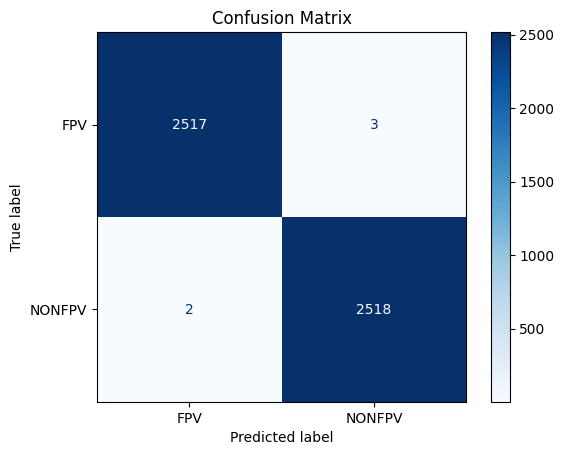


Classification Report:
              precision    recall  f1-score   support

         FPV     0.9992    0.9988    0.9990      2520
      NONFPV     0.9988    0.9992    0.9990      2520

    accuracy                         0.9990      5040
   macro avg     0.9990    0.9990    0.9990      5040
weighted avg     0.9990    0.9990    0.9990      5040


Showing 5 misclassified images:


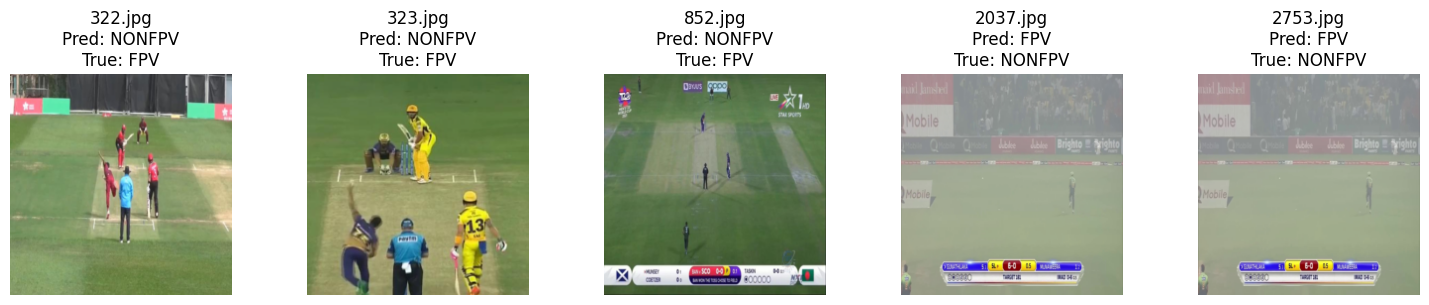

In [12]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import torch
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandAugment

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import CosineAnnealingLR

import torchmetrics
import timm
!pip -q install split-folders
import splitfolders

# =========================
# Setup
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.manual_seed(42)
np.random.seed(42)

# Hyperparameters
batch_size = 48
img_height, img_width = 224, 224
learning_rate = 2e-4
epochs = 20

# =========================
# Dataset Split
# =========================
# os.makedirs('/kaggle/working/Cricket', exist_ok=True)
# splitfolders.ratio(
#     '/kaggle/input/fpv-dataset/Hybrid_Dataset',
#     output='/kaggle/working/Cricket',
#     seed=42,
#     ratio=(.5, .1, .4),  # train, val, test
#     move=False
# )

# =========================
# DataModule
# =========================
class FireDataModule(pl.LightningDataModule):
    def __init__(self, path="/kaggle/working/Cricket"):
        super().__init__()
        self.PATH = path

    def setup(self, stage=None):
        train_transform = Compose([
            Resize((img_height, img_width)),
            RandAugment(num_ops=2, magnitude=9),
            ToTensor(),
            Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        test_transform = Compose([
            Resize((img_height, img_width)),
            ToTensor(),
            Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        if stage in ("fit", None):
            self.train = datasets.ImageFolder(os.path.join(self.PATH, 'train'), transform=train_transform)
            self.val = datasets.ImageFolder(os.path.join(self.PATH, 'val'), transform=test_transform)
        if stage in ("test", None):
            self.test = datasets.ImageFolder(os.path.join(self.PATH, 'test'), transform=test_transform)

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=batch_size, num_workers=2)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=batch_size, num_workers=2)

# =========================
# Model
# =========================
class PretrainedMobileNetV3(pl.LightningModule):
    def __init__(self, learning_rate=2e-4):
        super().__init__()
        self.save_hyperparameters()
        # Binary classification -> output 1 logit
        self.model = timm.create_model("mobilenetv3_small_100", pretrained=True, num_classes=1)

        # # 🔒 Freeze block 2 and block 4
        # for idx in [0,3,5]:
        #     for param in self.model.blocks[idx].parameters():
        #         param.requires_grad = False

        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.val_acc = torchmetrics.Accuracy(task="binary")
        self.test_acc = torchmetrics.Accuracy(task="binary")
        self.test_precision = torchmetrics.Precision(task="binary", average='macro')
        self.test_recall = torchmetrics.Recall(task="binary", average='macro')
        self.test_f1 = torchmetrics.F1Score(task="binary", average='macro')

    def forward(self, x):
        return self.model(x).squeeze(1)  # shape: [B]

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        acc = self.train_acc(preds, y.int())
        self.log("train_loss", loss, on_epoch=True)
        self.log("train_acc", acc, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        acc = self.val_acc(preds, y.int())
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True)
        return {"val_loss": loss, "val_acc": acc}

    def on_train_epoch_end(self):
        train_loss = self.trainer.callback_metrics.get("train_loss")
        train_acc = self.trainer.callback_metrics.get("train_acc")
        val_loss = self.trainer.callback_metrics.get("val_loss")
        val_acc = self.trainer.callback_metrics.get("val_acc")
        print(f"Epoch {self.current_epoch + 1}: "
              f"[Train] Loss: {train_loss:.4f} | Acc: {train_acc:.4f} || "
              f"[Val] Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    def test_step(self, batch, _):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        self.test_acc(preds, y.int())
        self.test_precision(preds, y.int())
        self.test_recall(preds, y.int())
        self.test_f1(preds, y.int())
        self.log_dict({
            "test_loss": loss,
            "test_acc": self.test_acc,
            "test_precision": self.test_precision,
            "test_recall": self.test_recall,
            "test_f1": self.test_f1
        }, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.learning_rate, weight_decay=0.05)
        scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

# =========================
# Dataset Stats
# =========================
def print_dataset_statistics(data_module):
    train_dataset = data_module.train
    val_dataset = data_module.val
    test_dataset = data_module.test

    def count_per_class(dataset):
        counts = {cls: 0 for cls in dataset.classes}
        for _, label in dataset.samples:
            counts[dataset.classes[label]] += 1
        return counts

    print("\n========== Dataset Statistics ==========")
    print(f"Classes: {train_dataset.classes}")
    print(f"Total Training Samples: {len(train_dataset)} | {count_per_class(train_dataset)}")
    print(f"Total Validation Samples: {len(val_dataset)} | {count_per_class(val_dataset)}")
    print(f"Total Testing Samples: {len(test_dataset)} | {count_per_class(test_dataset)}")
    print(f"Total Samples : {len(train_dataset)+len(val_dataset)+len(test_dataset)}")
    print("========================================\n")

# =========================
# Training
# =========================
data_module = FireDataModule()
data_module.setup()
print_dataset_statistics(data_module)

mobilenet_model = PretrainedMobileNetV3()

callbacks = [
    ModelCheckpoint(monitor="val_loss", dirpath="/kaggle/working/mobilenetv3",
                    filename="mobilenetv3-{epoch:02d}-{val_loss:.5f}", save_top_k=1, mode="min"),
    EarlyStopping(monitor="val_loss", patience=3, mode="min"),
    LearningRateMonitor(logging_interval='epoch')
]

logger = CSVLogger(save_dir="/kaggle/working/mobilenetv3", name="mobilenetv3_logs")

trainer = pl.Trainer(
    max_epochs=epochs,
    accelerator="auto",
    callbacks=callbacks,
    logger=logger,
    log_every_n_steps=1
)

start = time.time()
trainer.fit(mobilenet_model, datamodule=data_module)
end = time.time()
print(f"\nTotal Training Time: {int((end - start) // 60)} min")

# =========================
# Evaluation
# =========================
def evaluate_model(model, data_module):
    model.eval().to(device)
    all_preds, all_labels, misclassified_images = [], [], []
    test_loader = data_module.test_dataloader()
    start_time = time.time()
    total_images = 0
    sample_paths = test_loader.dataset.samples

    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = torch.sigmoid(logits)
            preds_label = (preds > 0.5).long()
            all_preds.extend(preds_label.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

            batch_paths = [sample_paths[i][0] for i in range(batch_idx * test_loader.batch_size,
                                                            batch_idx * test_loader.batch_size + len(y))]
            for i in range(len(y)):
                if preds_label[i] != y[i]:
                    misclassified_images.append((
                        x[i].cpu(),
                        preds_label[i].item(),
                        y[i].item(),
                        batch_paths[i]
                    ))
            total_images += x.size(0)

    elapsed_time = time.time() - start_time
    fps = total_images / elapsed_time
    avg_time_per_image = elapsed_time / total_images

    print(f"\nInference Performance:")
    print(f"Total images:         {total_images}")
    print(f"Total inference time: {elapsed_time:.2f} seconds")
    print(f"Average FPS:          {fps:.2f} images/second")
    print(f"Avg time/image:       {avg_time_per_image:.4f} seconds")

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(cm, display_labels=test_loader.dataset.classes)
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()


    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4, target_names=test_loader.dataset.classes))

    if misclassified_images:
        print(f"\nShowing {len(misclassified_images)} misclassified images:")
        class_names = test_loader.dataset.classes
        cols = 5
        rows = (len(misclassified_images) + cols - 1) // cols
        plt.figure(figsize=(cols * 3, rows * 3))
        for idx, (img_tensor, pred, true, file_path) in enumerate(misclassified_images):
            img = img_tensor.permute(1, 2, 0).numpy()
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img = np.clip(img, 0, 1)
            plt.subplot(rows, cols, idx + 1)
            plt.imshow(img)
            filename = file_path.split("/")[-1]
            plt.title(f"{filename}\nPred: {class_names[pred]}\nTrue: {class_names[true]}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("\nNo misclassified images found.")

mobilenet_model.to(device)
evaluate_model(mobilenet_model, data_module)


Using device: cuda

========== Dataset Statistics ==========
Classes: ['FPV', 'NONFPV']
Total Training Samples: 6300 | {'FPV': 3150, 'NONFPV': 3150}
Total Validation Samples: 1260 | {'FPV': 630, 'NONFPV': 630}
Total Testing Samples: 5040 | {'FPV': 2520, 'NONFPV': 2520}
Total Samples : 12600



/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /kaggle/working/mobilenetv3 exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: [Train] Loss: 0.2178 | Acc: 0.9686 || [Val] Loss: 0.0454 | Acc: 0.9881


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: [Train] Loss: 0.0510 | Acc: 0.9913 || [Val] Loss: 0.0069 | Acc: 0.9968


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: [Train] Loss: 0.0368 | Acc: 0.9927 || [Val] Loss: 0.0015 | Acc: 0.9992


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: [Train] Loss: 0.0113 | Acc: 0.9963 || [Val] Loss: 0.0021 | Acc: 0.9984


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: [Train] Loss: 0.0084 | Acc: 0.9973 || [Val] Loss: 0.0059 | Acc: 0.9960


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: [Train] Loss: 0.0177 | Acc: 0.9962 || [Val] Loss: 0.0044 | Acc: 0.9984

Total Training Time: 6 min

Inference Performance:
Total images:         5040
Total inference time: 41.04 seconds
Average FPS:          122.80 images/second
Avg time/image:       0.0081 seconds


<Figure size 600x500 with 0 Axes>

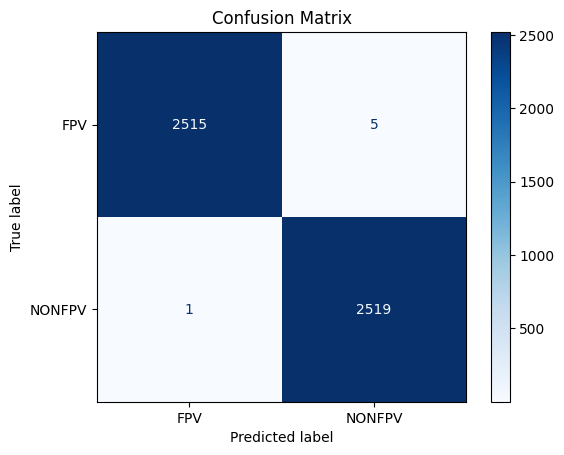


Classification Report:
              precision    recall  f1-score   support

         FPV     0.9996    0.9980    0.9988      2520
      NONFPV     0.9980    0.9996    0.9988      2520

    accuracy                         0.9988      5040
   macro avg     0.9988    0.9988    0.9988      5040
weighted avg     0.9988    0.9988    0.9988      5040


Showing 6 misclassified images:


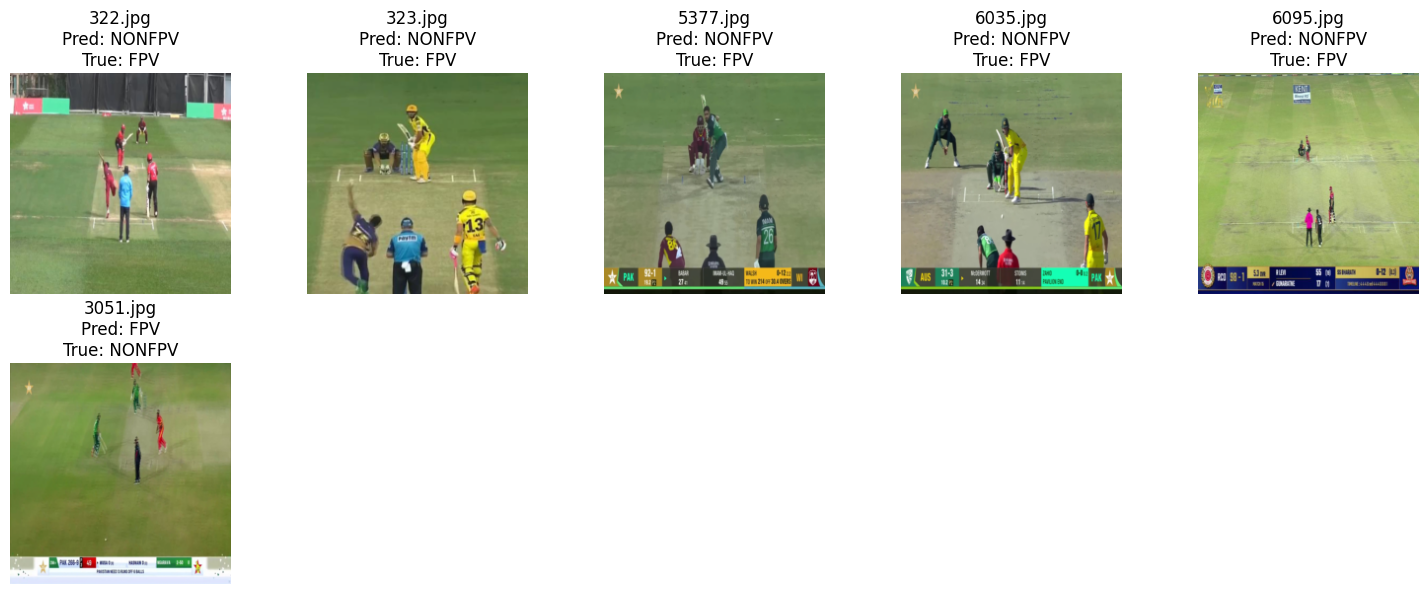

In [13]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import torch
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandAugment

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import CosineAnnealingLR

import torchmetrics
import timm
!pip -q install split-folders
import splitfolders

# =========================
# Setup
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.manual_seed(42)
np.random.seed(42)

# Hyperparameters
batch_size = 48
img_height, img_width = 224, 224
learning_rate = 2e-4
epochs = 20

# =========================
# Dataset Split
# =========================
# os.makedirs('/kaggle/working/Cricket', exist_ok=True)
# splitfolders.ratio(
#     '/kaggle/input/fpv-dataset/Hybrid_Dataset',
#     output='/kaggle/working/Cricket',
#     seed=42,
#     ratio=(.5, .1, .4),  # train, val, test
#     move=False
# )

# =========================
# DataModule
# =========================
class FireDataModule(pl.LightningDataModule):
    def __init__(self, path="/kaggle/working/Cricket"):
        super().__init__()
        self.PATH = path

    def setup(self, stage=None):
        train_transform = Compose([
            Resize((img_height, img_width)),
            RandAugment(num_ops=2, magnitude=9),
            ToTensor(),
            Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        test_transform = Compose([
            Resize((img_height, img_width)),
            ToTensor(),
            Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        if stage in ("fit", None):
            self.train = datasets.ImageFolder(os.path.join(self.PATH, 'train'), transform=train_transform)
            self.val = datasets.ImageFolder(os.path.join(self.PATH, 'val'), transform=test_transform)
        if stage in ("test", None):
            self.test = datasets.ImageFolder(os.path.join(self.PATH, 'test'), transform=test_transform)

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=batch_size, num_workers=2)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=batch_size, num_workers=2)

# =========================
# Model
# =========================
class PretrainedMobileNetV3(pl.LightningModule):
    def __init__(self, learning_rate=2e-4):
        super().__init__()
        self.save_hyperparameters()
        # Binary classification -> output 1 logit
        self.model = timm.create_model("mobilenetv3_small_100", pretrained=True, num_classes=1)

        # 🔒 Freeze block 2 and block 4
        for idx in [1,0,3,5]:
            for param in self.model.blocks[idx].parameters():
                param.requires_grad = False

        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.val_acc = torchmetrics.Accuracy(task="binary")
        self.test_acc = torchmetrics.Accuracy(task="binary")
        self.test_precision = torchmetrics.Precision(task="binary", average='macro')
        self.test_recall = torchmetrics.Recall(task="binary", average='macro')
        self.test_f1 = torchmetrics.F1Score(task="binary", average='macro')

    def forward(self, x):
        return self.model(x).squeeze(1)  # shape: [B]

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        acc = self.train_acc(preds, y.int())
        self.log("train_loss", loss, on_epoch=True)
        self.log("train_acc", acc, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        acc = self.val_acc(preds, y.int())
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True)
        return {"val_loss": loss, "val_acc": acc}

    def on_train_epoch_end(self):
        train_loss = self.trainer.callback_metrics.get("train_loss")
        train_acc = self.trainer.callback_metrics.get("train_acc")
        val_loss = self.trainer.callback_metrics.get("val_loss")
        val_acc = self.trainer.callback_metrics.get("val_acc")
        print(f"Epoch {self.current_epoch + 1}: "
              f"[Train] Loss: {train_loss:.4f} | Acc: {train_acc:.4f} || "
              f"[Val] Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    def test_step(self, batch, _):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        self.test_acc(preds, y.int())
        self.test_precision(preds, y.int())
        self.test_recall(preds, y.int())
        self.test_f1(preds, y.int())
        self.log_dict({
            "test_loss": loss,
            "test_acc": self.test_acc,
            "test_precision": self.test_precision,
            "test_recall": self.test_recall,
            "test_f1": self.test_f1
        }, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.learning_rate, weight_decay=0.05)
        scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

# =========================
# Dataset Stats
# =========================
def print_dataset_statistics(data_module):
    train_dataset = data_module.train
    val_dataset = data_module.val
    test_dataset = data_module.test

    def count_per_class(dataset):
        counts = {cls: 0 for cls in dataset.classes}
        for _, label in dataset.samples:
            counts[dataset.classes[label]] += 1
        return counts

    print("\n========== Dataset Statistics ==========")
    print(f"Classes: {train_dataset.classes}")
    print(f"Total Training Samples: {len(train_dataset)} | {count_per_class(train_dataset)}")
    print(f"Total Validation Samples: {len(val_dataset)} | {count_per_class(val_dataset)}")
    print(f"Total Testing Samples: {len(test_dataset)} | {count_per_class(test_dataset)}")
    print(f"Total Samples : {len(train_dataset)+len(val_dataset)+len(test_dataset)}")
    print("========================================\n")

# =========================
# Training
# =========================
data_module = FireDataModule()
data_module.setup()
print_dataset_statistics(data_module)

mobilenet_model = PretrainedMobileNetV3()

callbacks = [
    ModelCheckpoint(monitor="val_loss", dirpath="/kaggle/working/mobilenetv3",
                    filename="mobilenetv3-{epoch:02d}-{val_loss:.5f}", save_top_k=1, mode="min"),
    EarlyStopping(monitor="val_loss", patience=3, mode="min"),
    LearningRateMonitor(logging_interval='epoch')
]

logger = CSVLogger(save_dir="/kaggle/working/mobilenetv3", name="mobilenetv3_logs")

trainer = pl.Trainer(
    max_epochs=epochs,
    accelerator="auto",
    callbacks=callbacks,
    logger=logger,
    log_every_n_steps=1
)

start = time.time()
trainer.fit(mobilenet_model, datamodule=data_module)
end = time.time()
print(f"\nTotal Training Time: {int((end - start) // 60)} min")

# =========================
# Evaluation
# =========================
def evaluate_model(model, data_module):
    model.eval().to(device)
    all_preds, all_labels, misclassified_images = [], [], []
    test_loader = data_module.test_dataloader()
    start_time = time.time()
    total_images = 0
    sample_paths = test_loader.dataset.samples

    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = torch.sigmoid(logits)
            preds_label = (preds > 0.5).long()
            all_preds.extend(preds_label.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

            batch_paths = [sample_paths[i][0] for i in range(batch_idx * test_loader.batch_size,
                                                            batch_idx * test_loader.batch_size + len(y))]
            for i in range(len(y)):
                if preds_label[i] != y[i]:
                    misclassified_images.append((
                        x[i].cpu(),
                        preds_label[i].item(),
                        y[i].item(),
                        batch_paths[i]
                    ))
            total_images += x.size(0)

    elapsed_time = time.time() - start_time
    fps = total_images / elapsed_time
    avg_time_per_image = elapsed_time / total_images

    print(f"\nInference Performance:")
    print(f"Total images:         {total_images}")
    print(f"Total inference time: {elapsed_time:.2f} seconds")
    print(f"Average FPS:          {fps:.2f} images/second")
    print(f"Avg time/image:       {avg_time_per_image:.4f} seconds")

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(cm, display_labels=test_loader.dataset.classes)
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()


    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4, target_names=test_loader.dataset.classes))

    if misclassified_images:
        print(f"\nShowing {len(misclassified_images)} misclassified images:")
        class_names = test_loader.dataset.classes
        cols = 5
        rows = (len(misclassified_images) + cols - 1) // cols
        plt.figure(figsize=(cols * 3, rows * 3))
        for idx, (img_tensor, pred, true, file_path) in enumerate(misclassified_images):
            img = img_tensor.permute(1, 2, 0).numpy()
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img = np.clip(img, 0, 1)
            plt.subplot(rows, cols, idx + 1)
            plt.imshow(img)
            filename = file_path.split("/")[-1]
            plt.title(f"{filename}\nPred: {class_names[pred]}\nTrue: {class_names[true]}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("\nNo misclassified images found.")

mobilenet_model.to(device)
evaluate_model(mobilenet_model, data_module)


In [3]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import torch
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandAugment

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import CosineAnnealingLR

import torchmetrics
import timm
!pip -q install split-folders
import splitfolders

# =========================
# Setup
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.manual_seed(42)
np.random.seed(42)

# Hyperparameters
batch_size = 48
img_height, img_width = 224, 224
learning_rate = 2e-4
epochs = 20

# =========================
# Dataset Split
# =========================
# os.makedirs('/kaggle/working/Cricket', exist_ok=True)
# splitfolders.ratio(
#     '/kaggle/input/fpv-dataset/Hybrid_Dataset',
#     output='/kaggle/working/Cricket',
#     seed=42,
#     ratio=(.5, .1, .4),  # train, val, test
#     move=False
# )


# =========================
# Model
# =========================
class PretrainedMobileNetV3(pl.LightningModule):
    def __init__(self, learning_rate=2e-4):
        super().__init__()
        self.save_hyperparameters()
        # Binary classification -> output 1 logit
        self.model = timm.create_model("mobilenetv3_small_100", pretrained=True, num_classes=1)

        # 🔒 Freeze block 2 and block 4
        for idx in [1,0,3,5]:
            for param in self.model.blocks[idx].parameters():
                param.requires_grad = False

        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.val_acc = torchmetrics.Accuracy(task="binary")
        self.test_acc = torchmetrics.Accuracy(task="binary")
        self.test_precision = torchmetrics.Precision(task="binary", average='macro')
        self.test_recall = torchmetrics.Recall(task="binary", average='macro')
        self.test_f1 = torchmetrics.F1Score(task="binary", average='macro')

    def forward(self, x):
        return self.model(x).squeeze(1)  # shape: [B]

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        acc = self.train_acc(preds, y.int())
        self.log("train_loss", loss, on_epoch=True)
        self.log("train_acc", acc, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        acc = self.val_acc(preds, y.int())
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True)
        return {"val_loss": loss, "val_acc": acc}

    def on_train_epoch_end(self):
        train_loss = self.trainer.callback_metrics.get("train_loss")
        train_acc = self.trainer.callback_metrics.get("train_acc")
        val_loss = self.trainer.callback_metrics.get("val_loss")
        val_acc = self.trainer.callback_metrics.get("val_acc")
        print(f"Epoch {self.current_epoch + 1}: "
              f"[Train] Loss: {train_loss:.4f} | Acc: {train_acc:.4f} || "
              f"[Val] Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    def test_step(self, batch, _):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        self.test_acc(preds, y.int())
        self.test_precision(preds, y.int())
        self.test_recall(preds, y.int())
        self.test_f1(preds, y.int())
        self.log_dict({
            "test_loss": loss,
            "test_acc": self.test_acc,
            "test_precision": self.test_precision,
            "test_recall": self.test_recall,
            "test_f1": self.test_f1
        }, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.learning_rate, weight_decay=0.05)
        scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

# mobilenet_model = PretrainedMobileNetV3()
from torchinfo import summary
import torch

x = torch.randn(1, 3, 224, 224)

model_small = PretrainedMobileNetV3()

print("\n--- MobileNetV3 Small (full detail) ---")
summary(
    model_small, 
    input_size=(1, 3, 224, 224), 
    depth=4,           # traverse all layers recursively
    col_names=("input_size", "output_size", "num_params", "trainable")
)


Using device: cuda

--- MobileNetV3 Small (full detail) ---


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
PretrainedMobileNetV3                              [1, 3, 224, 224]          [1]                       --                        Partial
├─MobileNetV3: 1-1                                 [1, 3, 224, 224]          [1, 1]                    --                        Partial
│    └─Conv2d: 2-1                                 [1, 3, 224, 224]          [1, 16, 112, 112]         432                       True
│    └─BatchNormAct2d: 2-2                         [1, 16, 112, 112]         [1, 16, 112, 112]         32                        True
│    │    └─Identity: 3-1                          [1, 16, 112, 112]         [1, 16, 112, 112]         --                        --
│    │    └─Hardswish: 3-2                         [1, 16, 112, 112]         [1, 16, 112, 112]         --                        --
│    └─Sequential: 2-3                             [1, 

Using device: cuda

========== Dataset Statistics ==========
Classes: ['FPV', 'NONFPV']
Total Training Samples: 6300 | {'FPV': 3150, 'NONFPV': 3150}
Total Validation Samples: 1260 | {'FPV': 630, 'NONFPV': 630}
Total Testing Samples: 5040 | {'FPV': 2520, 'NONFPV': 2520}
Total Samples : 12600



/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /kaggle/working/mobilenetv3 exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: [Train] Loss: 0.3059 | Acc: 0.9510 || [Val] Loss: 0.0564 | Acc: 0.9889


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: [Train] Loss: 0.0982 | Acc: 0.9817 || [Val] Loss: 0.0280 | Acc: 0.9929


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: [Train] Loss: 0.0831 | Acc: 0.9867 || [Val] Loss: 0.0120 | Acc: 0.9952


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: [Train] Loss: 0.0390 | Acc: 0.9922 || [Val] Loss: 0.0210 | Acc: 0.9952


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: [Train] Loss: 0.0261 | Acc: 0.9940 || [Val] Loss: 0.0295 | Acc: 0.9960


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: [Train] Loss: 0.0454 | Acc: 0.9905 || [Val] Loss: 0.0068 | Acc: 0.9984


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: [Train] Loss: 0.0628 | Acc: 0.9890 || [Val] Loss: 0.0099 | Acc: 0.9984


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: [Train] Loss: 0.0264 | Acc: 0.9952 || [Val] Loss: 0.0156 | Acc: 0.9944


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: [Train] Loss: 0.0241 | Acc: 0.9963 || [Val] Loss: 0.0063 | Acc: 0.9984


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: [Train] Loss: 0.0193 | Acc: 0.9967 || [Val] Loss: 0.0132 | Acc: 0.9992


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: [Train] Loss: 0.0149 | Acc: 0.9965 || [Val] Loss: 0.0032 | Acc: 0.9976


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: [Train] Loss: 0.0096 | Acc: 0.9973 || [Val] Loss: 0.0114 | Acc: 0.9984


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: [Train] Loss: 0.0140 | Acc: 0.9968 || [Val] Loss: 0.0043 | Acc: 0.9992


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: [Train] Loss: 0.0127 | Acc: 0.9976 || [Val] Loss: 0.0025 | Acc: 0.9992


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: [Train] Loss: 0.0098 | Acc: 0.9971 || [Val] Loss: 0.0037 | Acc: 0.9992


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: [Train] Loss: 0.0044 | Acc: 0.9983 || [Val] Loss: 0.0049 | Acc: 0.9992


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: [Train] Loss: 0.0091 | Acc: 0.9984 || [Val] Loss: 0.0033 | Acc: 0.9984

Total Training Time: 18 min

Inference Performance:
Total images:         5040
Total inference time: 41.03 seconds
Average FPS:          122.85 images/second
Avg time/image:       0.0081 seconds


<Figure size 600x500 with 0 Axes>

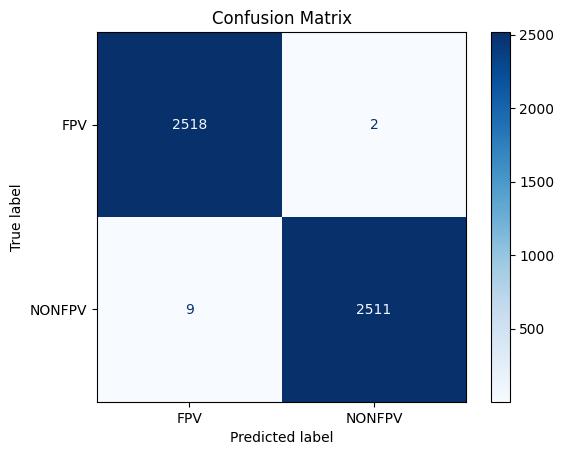


Classification Report:
              precision    recall  f1-score   support

         FPV     0.9964    0.9992    0.9978      2520
      NONFPV     0.9992    0.9964    0.9978      2520

    accuracy                         0.9978      5040
   macro avg     0.9978    0.9978    0.9978      5040
weighted avg     0.9978    0.9978    0.9978      5040


Showing 11 misclassified images:


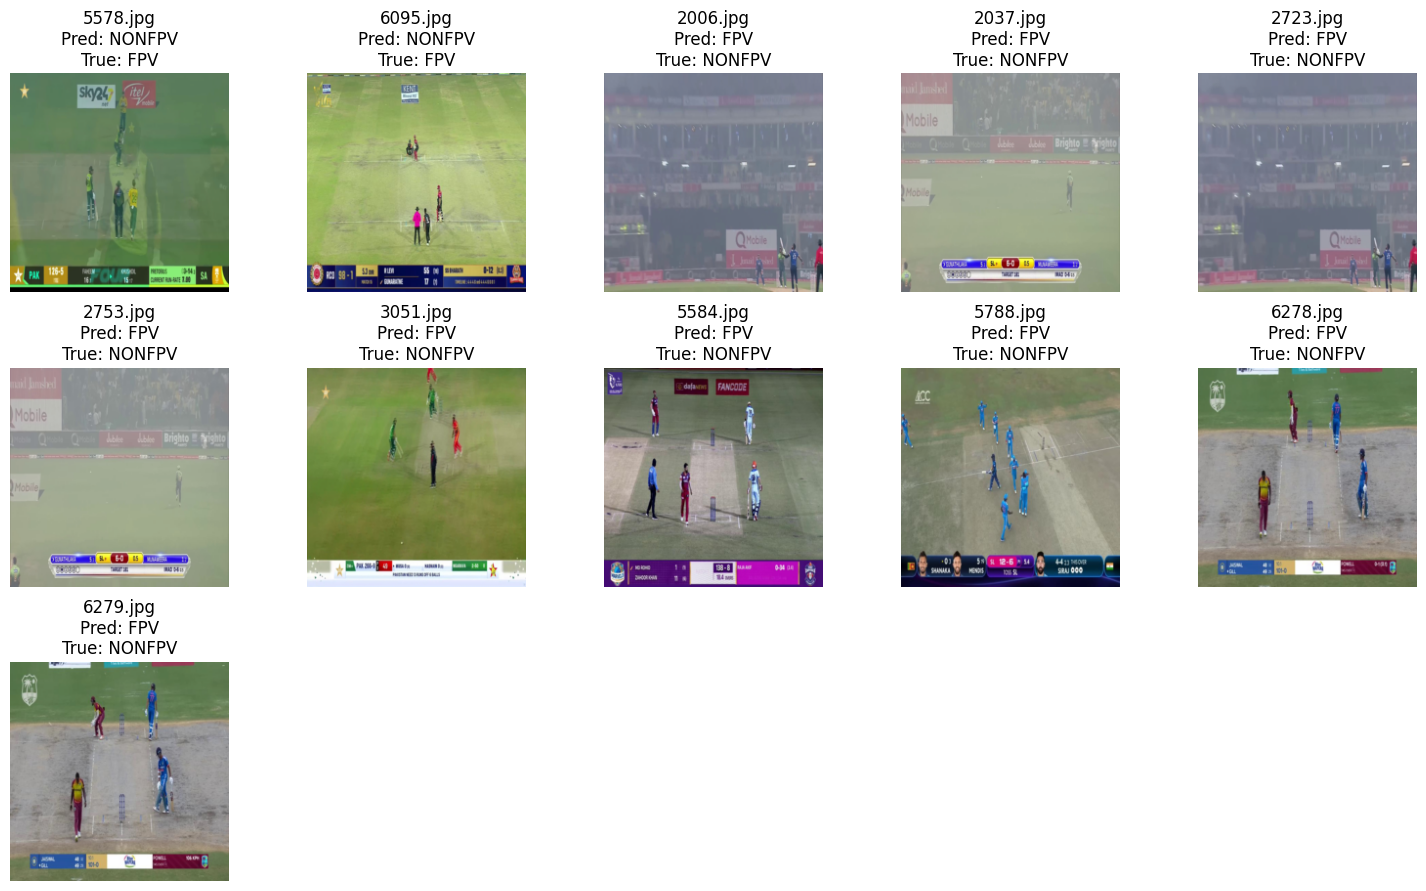

In [14]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import torch
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandAugment

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import CosineAnnealingLR

import torchmetrics
import timm
!pip -q install split-folders
import splitfolders

# =========================
# Setup
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.manual_seed(42)
np.random.seed(42)

# Hyperparameters
batch_size = 48
img_height, img_width = 224, 224
learning_rate = 2e-4
epochs = 20

# =========================
# Dataset Split
# =========================
# os.makedirs('/kaggle/working/Cricket', exist_ok=True)
# splitfolders.ratio(
#     '/kaggle/input/fpv-dataset/Hybrid_Dataset',
#     output='/kaggle/working/Cricket',
#     seed=42,
#     ratio=(.5, .1, .4),  # train, val, test
#     move=False
# )

# =========================
# DataModule
# =========================
class FireDataModule(pl.LightningDataModule):
    def __init__(self, path="/kaggle/working/Cricket"):
        super().__init__()
        self.PATH = path

    def setup(self, stage=None):
        train_transform = Compose([
            Resize((img_height, img_width)),
            RandAugment(num_ops=2, magnitude=9),
            ToTensor(),
            Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        test_transform = Compose([
            Resize((img_height, img_width)),
            ToTensor(),
            Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        if stage in ("fit", None):
            self.train = datasets.ImageFolder(os.path.join(self.PATH, 'train'), transform=train_transform)
            self.val = datasets.ImageFolder(os.path.join(self.PATH, 'val'), transform=test_transform)
        if stage in ("test", None):
            self.test = datasets.ImageFolder(os.path.join(self.PATH, 'test'), transform=test_transform)

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=batch_size, num_workers=2)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=batch_size, num_workers=2)

# =========================
# Model
# =========================
class PretrainedMobileNetV3(pl.LightningModule):
    def __init__(self, learning_rate=2e-4):
        super().__init__()
        self.save_hyperparameters()
        # Binary classification -> output 1 logit
        self.model = timm.create_model("mobilenetv3_small_100", pretrained=True, num_classes=1)

        # 🔒 Freeze block 2 and block 4
        for idx in [1,0,3,5,4]:
            for param in self.model.blocks[idx].parameters():
                param.requires_grad = False

        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.val_acc = torchmetrics.Accuracy(task="binary")
        self.test_acc = torchmetrics.Accuracy(task="binary")
        self.test_precision = torchmetrics.Precision(task="binary", average='macro')
        self.test_recall = torchmetrics.Recall(task="binary", average='macro')
        self.test_f1 = torchmetrics.F1Score(task="binary", average='macro')

    def forward(self, x):
        return self.model(x).squeeze(1)  # shape: [B]

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        acc = self.train_acc(preds, y.int())
        self.log("train_loss", loss, on_epoch=True)
        self.log("train_acc", acc, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        acc = self.val_acc(preds, y.int())
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True)
        return {"val_loss": loss, "val_acc": acc}

    def on_train_epoch_end(self):
        train_loss = self.trainer.callback_metrics.get("train_loss")
        train_acc = self.trainer.callback_metrics.get("train_acc")
        val_loss = self.trainer.callback_metrics.get("val_loss")
        val_acc = self.trainer.callback_metrics.get("val_acc")
        print(f"Epoch {self.current_epoch + 1}: "
              f"[Train] Loss: {train_loss:.4f} | Acc: {train_acc:.4f} || "
              f"[Val] Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    def test_step(self, batch, _):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        self.test_acc(preds, y.int())
        self.test_precision(preds, y.int())
        self.test_recall(preds, y.int())
        self.test_f1(preds, y.int())
        self.log_dict({
            "test_loss": loss,
            "test_acc": self.test_acc,
            "test_precision": self.test_precision,
            "test_recall": self.test_recall,
            "test_f1": self.test_f1
        }, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.learning_rate, weight_decay=0.05)
        scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

# =========================
# Dataset Stats
# =========================
def print_dataset_statistics(data_module):
    train_dataset = data_module.train
    val_dataset = data_module.val
    test_dataset = data_module.test

    def count_per_class(dataset):
        counts = {cls: 0 for cls in dataset.classes}
        for _, label in dataset.samples:
            counts[dataset.classes[label]] += 1
        return counts

    print("\n========== Dataset Statistics ==========")
    print(f"Classes: {train_dataset.classes}")
    print(f"Total Training Samples: {len(train_dataset)} | {count_per_class(train_dataset)}")
    print(f"Total Validation Samples: {len(val_dataset)} | {count_per_class(val_dataset)}")
    print(f"Total Testing Samples: {len(test_dataset)} | {count_per_class(test_dataset)}")
    print(f"Total Samples : {len(train_dataset)+len(val_dataset)+len(test_dataset)}")
    print("========================================\n")

# =========================
# Training
# =========================
data_module = FireDataModule()
data_module.setup()
print_dataset_statistics(data_module)

mobilenet_model = PretrainedMobileNetV3()

callbacks = [
    ModelCheckpoint(monitor="val_loss", dirpath="/kaggle/working/mobilenetv3",
                    filename="mobilenetv3-{epoch:02d}-{val_loss:.5f}", save_top_k=1, mode="min"),
    EarlyStopping(monitor="val_loss", patience=3, mode="min"),
    LearningRateMonitor(logging_interval='epoch')
]

logger = CSVLogger(save_dir="/kaggle/working/mobilenetv3", name="mobilenetv3_logs")

trainer = pl.Trainer(
    max_epochs=epochs,
    accelerator="auto",
    callbacks=callbacks,
    logger=logger,
    log_every_n_steps=1
)

start = time.time()
trainer.fit(mobilenet_model, datamodule=data_module)
end = time.time()
print(f"\nTotal Training Time: {int((end - start) // 60)} min")

# =========================
# Evaluation
# =========================
def evaluate_model(model, data_module):
    model.eval().to(device)
    all_preds, all_labels, misclassified_images = [], [], []
    test_loader = data_module.test_dataloader()
    start_time = time.time()
    total_images = 0
    sample_paths = test_loader.dataset.samples

    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = torch.sigmoid(logits)
            preds_label = (preds > 0.5).long()
            all_preds.extend(preds_label.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

            batch_paths = [sample_paths[i][0] for i in range(batch_idx * test_loader.batch_size,
                                                            batch_idx * test_loader.batch_size + len(y))]
            for i in range(len(y)):
                if preds_label[i] != y[i]:
                    misclassified_images.append((
                        x[i].cpu(),
                        preds_label[i].item(),
                        y[i].item(),
                        batch_paths[i]
                    ))
            total_images += x.size(0)

    elapsed_time = time.time() - start_time
    fps = total_images / elapsed_time
    avg_time_per_image = elapsed_time / total_images

    print(f"\nInference Performance:")
    print(f"Total images:         {total_images}")
    print(f"Total inference time: {elapsed_time:.2f} seconds")
    print(f"Average FPS:          {fps:.2f} images/second")
    print(f"Avg time/image:       {avg_time_per_image:.4f} seconds")

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(cm, display_labels=test_loader.dataset.classes)
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()


    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4, target_names=test_loader.dataset.classes))

    if misclassified_images:
        print(f"\nShowing {len(misclassified_images)} misclassified images:")
        class_names = test_loader.dataset.classes
        cols = 5
        rows = (len(misclassified_images) + cols - 1) // cols
        plt.figure(figsize=(cols * 3, rows * 3))
        for idx, (img_tensor, pred, true, file_path) in enumerate(misclassified_images):
            img = img_tensor.permute(1, 2, 0).numpy()
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img = np.clip(img, 0, 1)
            plt.subplot(rows, cols, idx + 1)
            plt.imshow(img)
            filename = file_path.split("/")[-1]
            plt.title(f"{filename}\nPred: {class_names[pred]}\nTrue: {class_names[true]}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("\nNo misclassified images found.")

mobilenet_model.to(device)
evaluate_model(mobilenet_model, data_module)

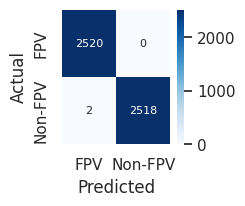

In [8]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = [[2520, 0],
    [2, 2518]]
A = ['FPV', 'Non-FPV']
df_cm = pd.DataFrame(array, A, A)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize=(1.75,1.75))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, cmap='Blues', annot=True, annot_kws={"size": 8},fmt='g') # font size

plt.show()

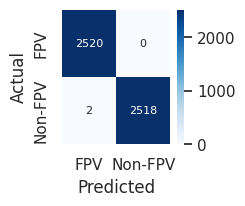

In [9]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = [[2520, 0],
    [2, 2518]]
A = ['FPV', 'Non-FPV']
df_cm = pd.DataFrame(array, A, A)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

plt.figure(figsize=(1.75,1.75))
sn.set(font_scale=1)  # for label size
sn.heatmap(df_cm, cmap='Blues', annot=True, annot_kws={"size": 8}, fmt='g')  # font size

# Save image
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches="tight")

plt.show()


In [4]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import torch
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandAugment

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import CosineAnnealingLR

import torchmetrics
import timm
!pip -q install split-folders
import splitfolders

# =========================
# Setup
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.manual_seed(42)
np.random.seed(42)

# Hyperparameters
batch_size = 48
img_height, img_width = 224, 224
learning_rate = 2e-4
epochs = 20

# =========================
# Dataset Split
# =========================
# os.makedirs('/kaggle/working/Cricket', exist_ok=True)
# splitfolders.ratio(
#     '/kaggle/input/fpv-dataset/Hybrid_Dataset',
#     output='/kaggle/working/Cricket',
#     seed=42,
#     ratio=(.5, .1, .4),  # train, val, test
#     move=False
# )


# =========================
# Model
# =========================
class PretrainedMobileNetV3(pl.LightningModule):
    def __init__(self, learning_rate=2e-4):
        super().__init__()
        self.save_hyperparameters()
        # Binary classification -> output 1 logit
        self.model = timm.create_model("mobilenetv3_small_100", pretrained=True, num_classes=1)

        # 🔒 Freeze block 2 and block 4
        for idx in [1,0,3,5,4]:
            for param in self.model.blocks[idx].parameters():
                param.requires_grad = False

        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.val_acc = torchmetrics.Accuracy(task="binary")
        self.test_acc = torchmetrics.Accuracy(task="binary")
        self.test_precision = torchmetrics.Precision(task="binary", average='macro')
        self.test_recall = torchmetrics.Recall(task="binary", average='macro')
        self.test_f1 = torchmetrics.F1Score(task="binary", average='macro')

    def forward(self, x):
        return self.model(x).squeeze(1)  # shape: [B]

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        acc = self.train_acc(preds, y.int())
        self.log("train_loss", loss, on_epoch=True)
        self.log("train_acc", acc, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        acc = self.val_acc(preds, y.int())
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True)
        return {"val_loss": loss, "val_acc": acc}

    def on_train_epoch_end(self):
        train_loss = self.trainer.callback_metrics.get("train_loss")
        train_acc = self.trainer.callback_metrics.get("train_acc")
        val_loss = self.trainer.callback_metrics.get("val_loss")
        val_acc = self.trainer.callback_metrics.get("val_acc")
        print(f"Epoch {self.current_epoch + 1}: "
              f"[Train] Loss: {train_loss:.4f} | Acc: {train_acc:.4f} || "
              f"[Val] Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    def test_step(self, batch, _):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        preds = torch.sigmoid(logits)
        self.test_acc(preds, y.int())
        self.test_precision(preds, y.int())
        self.test_recall(preds, y.int())
        self.test_f1(preds, y.int())
        self.log_dict({
            "test_loss": loss,
            "test_acc": self.test_acc,
            "test_precision": self.test_precision,
            "test_recall": self.test_recall,
            "test_f1": self.test_f1
        }, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.learning_rate, weight_decay=0.05)
        scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

# mobilenet_model = PretrainedMobileNetV3()
from torchinfo import summary
import torch

x = torch.randn(1, 3, 224, 224)

model_small = PretrainedMobileNetV3()

print("\n--- MobileNetV3 Small (full detail) ---")
summary(
    model_small, 
    input_size=(1, 3, 224, 224), 
    depth=4,           # traverse all layers recursively
    col_names=("input_size", "output_size", "num_params", "trainable")
)


Using device: cuda

--- MobileNetV3 Small (full detail) ---


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
PretrainedMobileNetV3                              [1, 3, 224, 224]          [1]                       --                        Partial
├─MobileNetV3: 1-1                                 [1, 3, 224, 224]          [1, 1]                    --                        Partial
│    └─Conv2d: 2-1                                 [1, 3, 224, 224]          [1, 16, 112, 112]         432                       True
│    └─BatchNormAct2d: 2-2                         [1, 16, 112, 112]         [1, 16, 112, 112]         32                        True
│    │    └─Identity: 3-1                          [1, 16, 112, 112]         [1, 16, 112, 112]         --                        --
│    │    └─Hardswish: 3-2                         [1, 16, 112, 112]         [1, 16, 112, 112]         --                        --
│    └─Sequential: 2-3                             [1, 